# 1. Import & Setting

## 1-1) Parameter Setting

In [2]:
DEFAULT_ENCODING = "cp949"
STATION_DF_PATH = "data/analysis/station_df.csv"
USER_DF_PATH = "data/analysis/user_df.csv"
TOUR_STATION_CANDIDATE_DF_PATH = "data/analysis/tour_station_candidate_df.csv"

## 1-2) Path Setting

In [3]:
import os
project_path = "C:/workspace/Bus Project"
os.chdir(project_path)

## 1-3) Import

In [4]:
import datetime
import numpy as np
import pandas as pd
import bus.analyzer as anz
import datetime
import requests
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
import xml.etree.ElementTree as elemTree
from sklearn.cluster import DBSCAN

## 1-4) 한글 폰트 설정

In [5]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

# 2. Library

## 2-1) Pandas Analysis Library

### * 이용량 분석

In [6]:
"""
* function        : object에 대한 subject의 이용량을 계산하여 반환
* s_df(subject_df): 이용자 정보를 담는 테이블
* o_df(object_df) : 타켓 정보를 담는 테이블
* u_df(usage_df)  : subject의 object이용 정보를 담는 테이블
* s_id(subject_id): subject_df의 키 컬럼 명시
* o_id(object_id) : object_df의 키 컬럼 명시 
* column : 이용량을 나타내는 결과 컬럼 네임 명시

* 매개변수에 대한 const 설정 보장(수정 안함)
"""
def get_usage(s_df, o_df, u_df, column = "usage",
                                     s_id = "subject_id", o_id="object_id"):
    # 필요한 컬럼 추출 및 결측치 제거
    o_df = o_df.copy()[[o_id]].dropna()
    s_df = s_df.copy()[[s_id]].dropna()
    u_df = u_df.copy()[[s_id, o_id]].dropna()
    
    # 원하는 정보만 추출 - u_df에서 s_df에 존재하는 id와 연관된 데이터만 추출한다.
    u_df = pd.merge(u_df, s_df, on=s_id, how="inner")
    
    # 이용량 계산
    u_df = u_df.groupby(by=o_id).count().reset_index().rename(columns={s_id:column})
    
    # 전체 object에 대해 이용량 컬럼 생성
    o_df = pd.merge(o_df, u_df, on=o_id, how="outer").fillna(0)

    return o_df

## 2-2) Bus Analysis Library

### * 정류장 이용량 분석

In [7]:
"""
* function: 이용자가 정류장에 승 하차를 몇번했는 지를 카운트 하여 원하는 컬럼명으로 생성
* orders  : 작업 내용 명세 리스트
            - form [order, order, ..., order]
            
* order   : 작업 내용 명세
            - form: = [user, behavior, column]
            
* user    : [ "total" | "tourist" | "remainder" ]
* behavior: [ "geton" | "getoff" ]
* column  : string
"""
def analyze_station_usage(station_df, user_df, usage_df, orders):
    
    # 관광객 여부가 판별되지 않은 경우에 대한 임시적 예외처리
    if "tourist" not in user_df.columns: 
        print("There is no column  'tourist'")
        print("create 'tourist' column that the value is False")
        user_df = user_df.copy()
        user_df["tourist"] = False
        
    # order에 대한 실직적인 데이터 저장___________________________________________________
    subject_dic = {"total": user_df, 
                   "tourist": user_df[user_df["tourist"] == True], 
                   "remainder":user_df[user_df["tourist"] == False]}
    
    usage_dic   = {"geton": usage_df.rename(columns={"geton_station_id":"station_id"}), 
                   "getoff":usage_df.rename(columns={"getoff_station_id":"station_id"})}
    
    # order수행___________________________________________________________________________
    for order in orders: 
        # get_usage()에 대한 파라미터 세팅________________________________________________
        user, behavior, column = order
        s_df = subject_dic[user]   # user에 따라 전체 이용자, 관광객 이용자, 나머지 이용자를 추출
        o_df = station_df          # 항상 station_df로 고정 
        u_df = usage_dic[behavior] # behavior에 따라 승차 또는 하차 데이터 컬럼을 station_id로 변경 for using get_usage()
        
        # get_usag() 수행 후 결과 반영____________________________________________________
        result_df = get_usage(s_df, o_df, u_df, column = column, s_id="user_id", o_id="station_id")
        if column in station_df.columns:
            del station_df[column]
        station_df[column] = result_df[column]
        
    return station_df

# 3. 정류장 & 이용자 추출 및 분석

## 3-1) 이용데이터 로딩

In [8]:
# 데이터 기간 설정
start_date = datetime.datetime(2019, 6, 1)
end_date = datetime.datetime(2019, 8, 29)

# 로딩할 파일 명 리스트 생성
input_path_list = anz.make_input_path(start_date, end_date)

# 전체 데이터 로딩 (multi)
usage_df = anz.parallel_load_total_usage_df(input_path_list)

In [9]:
station_df = pd.read_csv(STATION_DF_PATH, encoding = DEFAULT_ENCODING)

In [10]:
user_df = pd.read_csv(USER_DF_PATH, encoding = DEFAULT_ENCODING)

## 3-2) 정류장 & 이용자 추출

### 3-2-1) 전체 이용 정류장 추출

In [11]:
def create_station_df(usage_df):
    # 추출할 컬럼 리스트
    station_columns = ['station_id', 'station_name', 'station_longitude', 'station_latitude']
    
    # 승차, 하차 데이터 추출을 위한 컬럼 네임 변경 데이터 생성__________________________________________________
    geton_rename_dict = {}
    getoff_rename_dict = {}
    geton_station_columns = ['geton_station_id', 'geton_stataion_name', 'geton_station_longitude', 'geton_station_latitude']
    getoff_station_columns = ['getoff_station_id', 'getoff_station_name', 'getoff_station_longitude', 'getoff_station_latitude']
    for i, column in enumerate(station_columns):
        geton_rename_dict[geton_station_columns[i]] = column
        getoff_rename_dict[getoff_station_columns[i]] = column
    
    # 데이터 추출 (승차, 하차 개별)_____________________________________________________________________________
    geton_station_df = usage_df[geton_station_columns].drop_duplicates().rename(columns = geton_rename_dict).dropna()
    getoff_station_df = usage_df[getoff_station_columns].drop_duplicates().rename(columns = getoff_rename_dict).dropna()
    
    # 승차, 하차 데이터 병합____________________________________________________________________________________
    station_df = pd.concat([geton_station_df, getoff_station_df]).drop_duplicates()
    
    # 예외처리 - 하나의 id에 대하여 여러 경도, 위도 존재________________________________________________________
    id_count_df = pd.DataFrame(station_df['station_id'].value_counts()).reset_index().rename(columns = {'index':'station_id', 'station_id':'count'})
    exception_df = id_count_df[id_count_df['count'] >1]
    exception_id_list = list(exception_df['station_id'])
    for exception_id in exception_id_list:
        temp_df = station_df[station_df['station_id'] == exception_id]
        station_df = station_df[station_df['station_id'] != exception_id]
        station_df = pd.concat([station_df, temp_df.head(1)])
    
    station_df = station_df.sort_values(by="station_id")
    station_df.reset_index(inplace = True)
    del station_df["index"]
    return station_df

#정류장 추출
station_df = anz.create_station_df(usage_df)

### 3-2-2) 전체 이용자 추출

In [12]:
def create_user_df(usage_df):    # 유저 목록 생성
    user_df = usage_df[["user_id"]].drop_duplicates()
    user_df.reset_index(inplace = True)
    del user_df["index"]
    return user_df

# 유저 목록 생성
user_df = create_user_df(usage_df)

## 3-3) 정류장 및 이용자 분석

### 3-3-1) 정류장 주소 계산 및 컬럼 삽입

In [13]:
# 정류장 주소 추가 API 사용 함수
def get_address(loc_x, loc_y, mean_x = 126.531891, mean_y = 33.399409, 
                key = "E20F6493-C13D-3F6F-AC90-D5BB2F239901",
                url_form = "http://api.vworld.kr/req/address?service=address&request=getAddress&version=2.0&crs=epsg:4326&point={},{}&format=xml&type=both&zipcode=true&simple=false&key={}"):

    # 위도, 경도 반올림 for 빠른 예외처리를 위해
    loc_x = round(float(loc_x), 7)
    loc_y = round(float(loc_y), 7)
    
    url = url_form.format(loc_x, loc_y, key)
    response = requests.get(url)
    tree = elemTree.fromstring(response.text)
    
    try:
        #response(xml)로 부터 주소 데이터 추출
        address = tree.find("result").find("item[1]").find("text").text
    
    except: # 위도 경도가 바다 위에 있는 경우 API 결과의 주소 데이터가 비어있다.
#         print("현재 좌표: ",(loc_x, loc_y), "주소 없음")
        x_left = str(int(loc_x))
        y_left = str(int(loc_y))
        
        if mean_x < loc_x:
            x_right = str((int(loc_x*100000)-2)%100000)
        else:
            x_right = str((int(loc_x*100000)+2)%100000)
            
        if mean_y < loc_y:
            y_right = str((int(loc_y*100000)-2)%100000)
        else:
            y_right = str((int(loc_y*100000)+2)%100000)
            
        loc_x = float(x_left+"."+x_right)
        loc_y = float(y_left+"."+y_right)
        return get_address(loc_x, loc_y)
            
    return address

def set_station_address_column(df, longitude_column="station_longitude", latitude_columns = "station_latitude", result_column = "station_address"):
    df = pd.DataFrame.copy(df)
    
    if result_column in df.columns:# result_columns이 이미 존재한다면 제거
        del df[result_column]
        
    df[result_column] = ""
    for i in tqdm(df.index):
        df.loc[i, result_column] = get_address(float(df.loc[i, longitude_column]), float(df.loc[i, latitude_columns]))
    
    return df

station_df = set_station_address_column(station_df)

100%|██████████████████████████████████████████████████████████████████████████████| 3654/3654 [04:45<00:00, 12.80it/s]


### 3-3-2) 정류장 별 이용량 계산 및 컬럼 삽입

In [14]:
# analyze_station_usage()에 대한 작업 내용 파라미터 셋
orders = [["total",   "geton",  "total_geton"],
          ["total",   "getoff", "total_getoff"]]
# 전체 이용자에 대한 정류장별 이용량 분석 수행
station_df = analyze_station_usage(station_df, user_df, usage_df, orders)

There is no column  'tourist'
create 'tourist' column that the value is False


### 3-3-3) 정류장 별 출입정류장(공항, 항만) 판단 및 컬럼 삽입

In [15]:
"""
* function: _object가 comparator_list의 임의의 요소와 관계가 있는지 판별
    - 관계: 비교자가 비교 대상의 부분 문자열이면 관계가 있다.
    
* target: 비교 대상
    - form: string
    
* comparators: 비교자 리스트
"""
def is_related(target, comparators):
    for comparator in comparators:
        if(target.find(comparator) != -1):
            return True
    return False

"""
* function: df에서 object_column에 해당하는데이터에 대해 comparator와 관계가 있는지 계산 
"""
def extract_related_stations(df, object_column, comparators):
    df = df.copy()
    df['related'] = df[object_column].apply(lambda x : is_related(str(x), comparators))
    df = df[df['related'] == True]
    del df["related"]
    return df

# 공항과 항만에 대한 이름 후보(정류장 이름의 부분 문자열) 데이터
airport_candidate_list = ["제주국제공항"]
harbor_candidate_list = ["국제여객터미널", "제주연안여객터미널", "제4부두", "제6부두", "임항로", "제주해양경찰서"]

"""
* function: target_df에 속하였는지 여부를 df에 result_column으로 삽입
"""
def insert_flag_column(df, target_df, id_column, result_column):
    target_df[result_column] = True
    target_df = target_df[[id_column, result_column]]
    if result_column in df.columns:
        del df[result_column]
    df = pd.merge(df, target_df, on=id_column, how="outer").fillna(False)
    return df
    
# 공항 정류장을 추출 후 station_df에 속성으로 삽입
airport_station_df = extract_related_stations(station_df, "station_name", airport_candidate_list)
station_df = insert_flag_column(station_df, airport_station_df, id_column = "station_id", result_column = "airport_flag")

# 항만 정류장을 추출 후 station_df에 속성으로 삽입
harbor_station_df = extract_related_stations(station_df, "station_name", harbor_candidate_list)
station_df = insert_flag_column(station_df, harbor_station_df, id_column = "station_id", result_column = "harbor_flag")

In [16]:
station_df[station_df["airport_flag"] | station_df["harbor_flag"]][["station_id", "station_name"]].sort_values(by="station_id")

,station_id,station_name
1498,108.0,제주연안여객터미널
860,109.0,제주연안여객터미널
2850,216.0,제주해양경찰서
1615,218.0,제4부두
2154,621.0,제주국제공항입구
4,638.0,제주국제공항(구제주방면)
61,1355.0,제주국제공항(신제주방면)
654,1579.0,제주국제공항(600번)
2145,2959.0,임항로
3650,2972.0,제주국제공항(종점)


### 3-3-4) 정류장의 관광정류장 여부 판단 및 컬럼 삽입

In [17]:
# 정류장의 관광정류장 여부 판별
def analyze_tour_station(station_df, candidate_df, result_column):
    station_df = station_df.copy()
    candidate_df = candidate_df.copy()
    candidate_df = candidate_df[["station_id", "candidate_flag"]]
    candidate_df = pd.merge(station_df, candidate_df, on="station_id")
    candidate_df = candidate_df[candidate_df["candidate_flag"] == True]
#     candidate_df = candidate_df[candidate_df['total_geton'] >= 150]
    candidate_df = candidate_df[candidate_df['total_geton'] >= 0]
    tour_station_df = candidate_df[["station_id", "candidate_flag"]]
    tour_station_df = tour_station_df.rename(columns={"candidate_flag":result_column})
    if result_column in station_df.columns:
        del station_df[result_column]
    station_df = pd.merge(station_df, tour_station_df, on="station_id", how="outer").fillna(False) 
    return station_df

# candidate_df는 기존의 station_df에 수작업으로 candidate컬럼 생성 요구
tour_station_candidate_df = pd.read_csv(TOUR_STATION_CANDIDATE_DF_PATH, low_memory=False, encoding = DEFAULT_ENCODING) #, dtype=dtype)
station_df = analyze_tour_station(station_df, tour_station_candidate_df, result_column="tour_station_flag")

In [18]:
station_df.head(1)

,station_id,station_name,station_longitude,station_latitude,station_address,total_geton,total_getoff,airport_flag,harbor_flag,tour_station_flag
0,988.0,납읍리사무소,126.32944,33.43944,제주특별자치도 제주시 애월읍 납읍리 1754-3,3209,527,False,False,False


In [19]:
df = station_df.copy()
df["total_usage"] = df["total_geton"] + df["total_getoff"]
df[df["tour_station_flag"]].sort_values(by="total_usage", ascending=False)[["station_id", "station_name", "total_usage"]].head(30)

,station_id,station_name,total_usage
32,280.0,동문로터리(동문시장),136848
89,279.0,동문로터리(동문시장),130410
16,325.0,관덕정,76221
450,186.0,은남동,70103
321,2053.0,중문환승정류장(중문우체국),69339
519,192.0,함덕환승정류장(함덕해수욕장),68325
21,222.0,삼양동주민센터,67729
275,2052.0,중문환승정류장(중문우체국),64337
133,324.0,관덕정,62753
549,198.0,함덕환승정류장(함덕해수욕장),60602


### 3-3-5) 이용자의 이용 날짜 수 계산 및 컬럼 삽입

In [20]:
def analyze_usage_date(user_df, usage_df):
    grouped = usage_df[["user_id", "base_date"]].drop_duplicates().groupby(by=["user_id"], as_index=False)
    first_date_df = grouped.min().rename(columns = {"base_date" : "first_date"})
    last_date_df = grouped.max().rename(columns = {"base_date" : "last_date"})
    use_days_df= grouped.count().rename(columns = {"base_date" : "use_days"})
    user_df = pd.merge(user_df, first_date_df, on="user_id")
    user_df = pd.merge(user_df, last_date_df, on="user_id")
    user_df = pd.merge(user_df, use_days_df, on="user_id")
    user_df['first_date'] = user_df['first_date'].apply(lambda x : datetime.datetime.strptime(str(x), "%Y%m%d").date()) 
    user_df['last_date'] = user_df['last_date'].apply(lambda x : datetime.datetime.strptime(str(x), "%Y%m%d").date())
    user_df["period"] = user_df["last_date"] - user_df["first_date"]
    user_df["period"] = user_df["period"].apply(lambda x : int(str(x).split(" ")[0])+1)
    return user_df

# 이용 날짜 수 분석
user_df = analyze_usage_date(user_df, usage_df)

### 3-3-6) 이용자의 이용 횟수 계산 및 컬럼 삽입

In [21]:
def analyze_usage_num(user_df, usage_df):
    grouped = usage_df[["user_id", "base_date"]].groupby(by=["user_id"], as_index=False)
    count_df = grouped.count().rename(columns = {"base_date" : "usage"})
    user_df = pd.merge(user_df, count_df, on="user_id")
    return user_df

# 버스 이용 횟수 분석
user_df = anz.analyze_usage_num(user_df, usage_df)

### 3-3-7) 이용자의 이용 비율 계산 및 컬럼 삽입

In [22]:
def analyze_usage_ratio(user_df):
    user_df['usage_ratio'] = user_df['use_days'].apply(lambda x : float(x))
    user_df['usage_ratio'] = user_df['usage_ratio']/user_df["period"]
    user_df['usage_ratio'] = user_df['usage_ratio'].apply(lambda x : int(x*100))
    return user_df

# def analyze_usage_ratio(user_df):
#     user_df['usage_ratio'] = user_df['usage'].apply(lambda x : float(x))
#     user_df['usage_ratio'] = user_df['usage_ratio']/user_df["period"]
#     user_df['usage_ratio'] = user_df['usage_ratio'].apply(lambda x : int(x*100))
#     return user_df

# 이용 비율 분석
user_df = analyze_usage_ratio(user_df)

### 3-3-8) 이용자의 출발지, 도착지 유형 분석 및 컬럼 삽입

In [23]:
def analyze_first_last_station_type(user_df, usage_df, station_df, first_column, last_column, case_column):
    #기존에 컬럼 값이 존재하면 삭제
    column_list = [first_column, last_column, case_column]
    for column in column_list:
        if column in user_df.columns:
            del user_df[column]
            
    # 출입정류장 추출
    airport_station_id_list = list(station_df[station_df["airport_flag"]]["station_id"])
    harbor_station_id_list  = list(station_df[station_df["harbor_flag"]]["station_id"])
    
    # user_id별 최초, 최종 이용 정류장 추출
    # 최종 하차의 경우 결측치는 -1로 대체
    grouped_usage_df = usage_df.sort_values(["geton_datetime"]).groupby(by=["user_id"], as_index=False)    
    first_usage_df = grouped_usage_df.first()[["user_id", "geton_station_id"]]
    last_usage_df = grouped_usage_df.last()[["user_id", "getoff_station_id"]].fillna(-1)
   

    # 첫 승차 및 최종 하차 정류장의 공항 또는 항만 여부 판단
    first_usage_df["first"] = first_usage_df["geton_station_id"].apply(lambda x : "airport" if np.float(x) in airport_station_id_list
                                                                                    else "harbor" if x in harbor_station_id_list
                                                                                    else "other")
    last_usage_df["last"] = last_usage_df["getoff_station_id"].apply(lambda x : "airport" if x in airport_station_id_list
                                                                                    else "harbor" if x in harbor_station_id_list
                                                                                    else "no_tag" if x == -1
                                                                                    else "other")
    
    first_usage_df = first_usage_df.copy()[["user_id", "first"]]
    last_usage_df = last_usage_df.copy()[["user_id", "last"]]
    
    flag_df = pd.merge(first_usage_df, last_usage_df, on = "user_id")
    # 첫 승차와 마지막 하차 정류장의 출입정류장 여부 판단
    flag_df["f"] = (flag_df["first"]=='airport') | (flag_df["first"]=='harbor')
    flag_df["l"] = (flag_df["last"]=='airport') | (flag_df["last"]=='harbor')
    
    flag_df["case"] = flag_df[["f", "l"]].apply(lambda x : "both" if x[0] & x[1] 
                                                else "first" if x[0] 
                                                else "last"  if x[1]
                                                else "neither", axis = 1)
    del flag_df["f"]
    del flag_df["l"]
    
    user_df = pd.merge(user_df, flag_df, on="user_id")
    return user_df

# 출발, 도작지 유형 분석
user_df = analyze_first_last_station_type(user_df, usage_df, station_df, "first", "last", "case")

### 3-3-9) 이용자의 특수정류장(출입, 관광) 이용 횟수 분석 및 컬럼 삽입

In [24]:
# 출입정류장 이용 횟수 분석
def analyze_visit_count(user_df, usage_df, target_station_df, result_column):
    # 속성 이름이 이미 쓰이고 있다면 제거
    if result_column in user_df.columns:
        del user_df[result_column]
    
    #필요한 속성만 추출
    target_station_df = target_station_df.copy()[["station_id"]]
    geton_df = usage_df.copy()[["user_id", "geton_station_id"]]
    getoff_df = usage_df.copy()[["user_id", "getoff_station_id"]].dropna()# 하차 데이터에 대해선 결측치 제거
    geton_df.rename(columns = {"geton_station_id":"station_id"}, inplace = True)
    getoff_df.rename(columns = {"getoff_station_id":"station_id"}, inplace = True)
    
    #승하차 정보 통합
    usage_df = pd.concat([geton_df, getoff_df])
    
    #중복 제거(동일 정류장에 대해 여러 번 방문한 경우 중복 처리)
    usage_df.drop_duplicates(inplace=True)
    
    #타켓 정류장 방문 데이터 추출
    usage_df = pd.merge(usage_df, target_station_df, on="station_id")
    
    #이용자별 방문 타켓 정류장 수 카운트
    usage_df = usage_df.groupby(by="user_id").count().reset_index().rename(columns={"station_id":result_column})
    
    # 이용자의 이용한 타켓 정류장 수 속성 삽입
    user_df = pd.merge(user_df, usage_df, on="user_id", how="outer")
    user_df.fillna(0, inplace=True)
    user_df[result_column] = user_df[result_column].apply(lambda x : int(x))
    return user_df

# 이용한 출입정류장(공항) 수 속성 삽입
airport_station_df = station_df[station_df["airport_flag"] == True]
user_df = analyze_visit_count(user_df, usage_df, airport_station_df, result_column="airport_count")

# 이용한 출입정류장(항만) 수 속성 삽입
harbor_station_df = station_df[station_df["harbor_flag"] == True]
user_df = analyze_visit_count(user_df, usage_df, harbor_station_df, result_column="harbor_count")

# 출입정류장 수 속성 통합
user_df["access_count"] = user_df["airport_count"] + user_df["harbor_count"]
# 이용한 관광정류장 수 속성 삽입
tour_station_df = station_df[station_df["tour_station_flag"] == True]
user_df = analyze_visit_count(user_df, usage_df, tour_station_df, result_column="tour_count")

### 3-3-10) 이용자의 관광객 여부 판단 및 컬럼 삽입

In [25]:
def extract_tourist(user_df, case, period, min_usage_ratio, min_tour_station_count):
    select = user_df.columns
    
    # 케이스 추출
    user_df = user_df[user_df["case"] == case]

    # 이용 기간 고려
    user_df = user_df[(period[0] <= user_df["period"]) & (user_df["period"] <= period[1])]
    
    # 이용 비율 고려 => 이용 비율은 관광객 여부에 큰 관계 없음
#     user_df = user_df[user_df['usage_ratio'] >= min_usage_ratio]
    
    # 방문한 관광 정류장 수 고려
    user_df = user_df[user_df["tour_count"] >= min_tour_station_count]
    
    return user_df

def analyze_and_insert_tourist_column(user_df, column_name = "result_column"):    
    if column_name in user_df.columns:
        del user_df[column_name]
    
    tourist_df_list = []

    tourist_df_list.append(extract_tourist(user_df, "both",    (2, 10), 70, 1))
    tourist_df_list.append(extract_tourist(user_df, "first",   (2, 10), 70, 3))
    tourist_df_list.append(extract_tourist(user_df, "last",    (2, 10), 80, 3))
    tourist_df_list.append(extract_tourist(user_df, "neither", (2, 10), 90, 4))

    tourist_df = pd.concat(tourist_df_list)[["user_id"]]
    tourist_df["tourist"] = True
    
    user_df = pd.merge(user_df, tourist_df, on = "user_id", how="outer").fillna(False)
    
    return user_df

# 관광객 분석
user_df = analyze_and_insert_tourist_column(user_df, column_name = "tourist")

### 3-3-11) 정류장 별 관광객 이용량 컬럼 삽입 

In [26]:
# analyze_station_usage()에 대한 작업 내용 파라미터 셋
orders = [["tourist", "geton",  "tourist_geton_count"],
          ["tourist", "getoff", "tourist_getoff_count"]]

# 관광객 이용자에 대한 정류장별 이용량 분석 수행
station_df = analyze_station_usage(station_df, user_df, usage_df, orders)

## 3-4) 정류장 및 이용자 분석 결과 출력

### 3-4-1) 정류장 분석 결과 출력

In [27]:
def show_station_acalyze(station_df):
    total_count = len(station_df)
    airport_count =len(station_df[station_df["airport_flag"]]) 
    harbor_count = len(station_df[station_df["harbor_flag"]])
    tour_count = len(station_df[station_df["tour_station_flag"]])
    print("전체 정류장 수: ", total_count, "개")
    print("공항 정류장 수: ", airport_count, "개")
    print("항만 정류장 수: ", harbor_count, "개")
    print("관광 정류장 수: ", tour_count, "개")
    
show_station_acalyze(station_df)

전체 정류장 수:  3654 개
공항 정류장 수:  9 개
항만 정류장 수:  7 개
관광 정류장 수:  485 개


### 3-4-2) 이용자 분석 결과 출력

In [28]:
def show_user_analyze(user_df):
    total_count = len(user_df)
    tourist_count = len(user_df[user_df["tourist"] == True])
    print("* Total ")
    print("  - %-7s: %d people"% ("User", total_count))
    print("  - %-7s: %d people"% ("Tourist", tourist_count))
    print("  - %-7s: %.1f%%" % ("Ratio", (tourist_count/total_count*100)))
    print("\n")
    
    case_list = ["both", "first", "last", "neither"]
    for case in case_list:
        df = user_df[user_df["case"] == case]
        total_count = len(df)
        tourist_count = len(df[df["tourist"] == True])
        print("*", case,)
        print("  - %-7s: %d people"% ("User", total_count))
        print("  - %-7s: %d people"% ("Tourist", tourist_count))
        print("  - %-7s: %.1f%%" % ("Ratio", (tourist_count/total_count*100)))
        print("\n")
    
    print("* airport user: %6d people"% (len(user_df[user_df["airport_count"]>=1])))
    print("* harbor user : %6d people"% (len(user_df[user_df["harbor_count"]>=1])))

show_user_analyze(user_df)

* Total 
  - User   : 726192 people
  - Tourist: 85929 people
  - Ratio  : 11.8%


* both
  - User   : 47629 people
  - Tourist: 31222 people
  - Ratio  : 65.6%


* first
  - User   : 131112 people
  - Tourist: 22743 people
  - Ratio  : 17.3%


* last
  - User   : 55006 people
  - Tourist: 10303 people
  - Ratio  : 18.7%


* neither
  - User   : 492445 people
  - Tourist: 21661 people
  - Ratio  : 4.4%


* airport user: 310758 people
* harbor user :   4785 people


In [29]:
df = user_df
df = df[(df["airport_count"] >=1)|(df["harbor_count"] >=1)]
df = df[df["case"] == "neither"]
df = df[df["tour_count"] == 0]
df

,user_id,first_date,last_date,use_days,period,usage,usage_ratio,first,last,case,airport_count,harbor_count,access_count,tour_count,tourist
51,8c031615f4216d40b5d96d1c6c206581933b7bc9bb364f...,2019-06-01,2019-08-14,30,75,66,40,other,other,neither,1,0,1,0,False
244,09a894b91d12dab5dee5919fdfb83f1a50e07b7f232ac5...,2019-06-01,2019-06-25,4,25,7,16,other,other,neither,1,0,1,0,False
483,2f9fac50c01a96cecf9d8c7fff4e0a83a3d7febb54a543...,2019-06-01,2019-08-15,19,76,20,25,other,other,neither,2,0,2,0,False
488,8f5b07e46c2f4aa018153fceb92e2cdf69cd854443e025...,2019-06-01,2019-08-28,36,89,52,40,other,other,neither,1,0,1,0,False
898,1ce1ea42189d3f1b50f2cbb1c0197fcf52c3b8db2727e7...,2019-06-01,2019-07-17,4,47,5,8,other,other,neither,2,0,2,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723937,6b806c0aaa1dce6950a687a260e93c9a01fd86fc4c71fd...,2019-08-28,2019-08-28,1,1,2,100,other,other,neither,1,0,1,0,False
724615,2d039a08d23a495f39f7698ecd3006b6b7a2f0d6ac6166...,2019-08-28,2019-08-28,1,1,2,100,other,other,neither,2,0,2,0,False
724650,513a4e2d671facb69aa6db6e8b64e7feb35a44ba09cfcb...,2019-08-28,2019-08-28,1,1,2,100,other,other,neither,2,0,2,0,False
725447,b651fd16eda0103fcf5fb70d4a14007aea2f8263c2418b...,2019-08-28,2019-08-28,1,1,2,100,other,other,neither,2,0,2,0,False


## 3-5) 정류장 및 이용자 저장

In [30]:
# 정류장 데이터 저장
station_df.to_csv(STATION_DF_PATH, encoding=DEFAULT_ENCODING, index=False)

# 이용자 데이터 저장
user_df.to_csv(USER_DF_PATH, encoding=DEFAULT_ENCODING, index=False)

# 4. 관광객 추출 알고리즘 검증

## 4-1) 제주 관광객 통계

### 4-1-1) 제주 관광객 통계자료

In [179]:
# 제주 관광객 수 데이터
TOURIST_NUM_STATS_DATA = {"2019_Jun":{"domestic_tourist":1155020, "foreign_tourist":152197}, 
                          "2019_Jul":{"domestic_tourist":1157447, "foreign_tourist":152629},
                          "2019_Aug":{"domestic_tourist":1243132, "foreign_tourist":178323}}


# 제주 관광객 체류 기간 데이터
STAY_PERIOD_STATS_DATA = {"period":  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
                          "domestic_tourist":[0.003, 0.057, 0.618, 0.238, 0.045, 0.013, 0.015, 0.003, 0.001, 0.001, 0.006, 0, 0, 0, 0],
                          "foreign_tourist": [0.006, 0.066, 0.280, 0.296, 0.217, 0.055, 0.035, 0.019, 0.006, 0.004, 0.016, 0, 0, 0, 0]}  

# 기타 데이터(버스 이용량, )
DOMESTIC_BUS_USAGE_RATIO = 0.032
FOREIGN_BUS_USAGE_RATIO  = 0.211
TAG_UTILIZATION = 0.847

### 4-1-2) 관광객 여부 및 유형(국내, 국외)별 이용자 수 추출

In [180]:
def get_jeju_tourist_num_df(tourist_num_stats_data, domestic_bus_usage_ratio, foreign_bus_usage_ratio):
    df = np.transpose(pd.DataFrame(tourist_num_stats_data))

    df["total_tourist"] = df["domestic_tourist"] + df["foreign_tourist"]
    

    df["domestic_bus_tourist"] = (df["domestic_tourist"] * domestic_bus_usage_ratio).apply(lambda x : int(x))
    df["foreign_bus_tourist"] = (df["foreign_tourist"] * foreign_bus_usage_ratio).apply(lambda x : int(x))
    df["total_bus_tourist"] = df["domestic_bus_tourist"] + df["foreign_bus_tourist"]
    return df

jeju_user_num_df = get_jeju_tourist_num_df(TOURIST_NUM_STATS_DATA, DOMESTIC_BUS_USAGE_RATIO, FOREIGN_BUS_USAGE_RATIO)
jeju_user_num_df.loc["total"] = jeju_user_num_df.sum() # 합계 계산
jeju_user_num_df

,domestic_tourist,foreign_tourist,total_tourist,domestic_bus_tourist,foreign_bus_tourist,total_bus_tourist
2019_Jun,1155020,152197,1307217,36960,32113,69073
2019_Jul,1157447,152629,1310076,37038,32204,69242
2019_Aug,1243132,178323,1421455,39780,37626,77406
total,3555599,483149,4038748,113778,101943,215721


### 4-1-3) 관관객 유형(국내, 국외)별 체류기간 비율 분포 추출

In [181]:
def get_jeju_stay_period_df(stay_period_stats_data, user_num_stats_df):
    df = pd.DataFrame(stay_period_stats_data)
    # 내국인, 외국인 관광객 비율 추출
    domestic = user_num_stats_df["domestic_bus_tourist"].sum()
    foreign = user_num_stats_df["foreign_bus_tourist"].sum()
    total = domestic + foreign
    domestic_ratio = domestic/total
    foreign_ratio = foreign/total
    df["total_tourist"] = df["domestic_tourist"]*domestic_ratio + df["foreign_tourist"]*foreign_ratio
    return df

jeju_stay_period_df = get_jeju_stay_period_df(STAY_PERIOD_STATS_DATA, jeju_user_num_df)
jeju_stay_period_df

,period,domestic_tourist,foreign_tourist,total_tourist
0,1,0.003,0.006,0.004418
1,2,0.057,0.066,0.061253
2,3,0.618,0.280,0.458272
3,4,0.238,0.296,0.265409
4,5,0.045,0.217,0.126282
5,6,0.013,0.055,0.032848
6,7,0.015,0.035,0.024451
7,8,0.003,0.019,0.010561
8,9,0.001,0.006,0.003363
9,10,0.001,0.004,0.002418


### 4-1-4) 관광객 유형(국내, 국외)별 체류기간 비율 분포 그래프

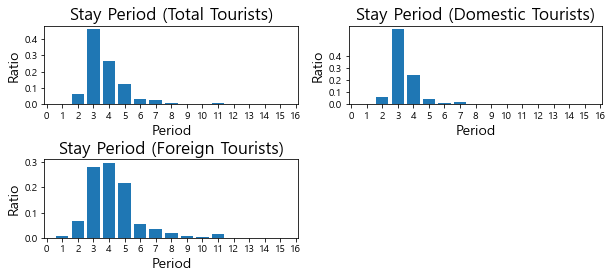

In [186]:
# df에서 x와 y속성을 넘기면 해당 데이터에 대한 막대그래프을 생성하여 반환
def draw_bar_graph_from_df_by_one_column(df, x_column, y_column, title, x_label, y_label):
    df = df[[x_column, y_column]]
    x = df[x_column]
    y = df[y_column]
    plt.title(title, fontsize=17)
    plt.xlabel(x_label, fontsize = 14)
    plt.ylabel(y_label, fontsize = 14)
    return plt.bar(x, y)

# df에서 x와 y속성들에 대한 막대그래프를 생성하여 반환
def draw_bar_graph_from_df_by_all_columns(df, x_column, y_columns, titles, x_label, y_label):
    n = len(y_columns)
    for i in range(n):
        plt.subplot(n, 2, i+1)
        plt.xticks(np.arange(0, 17, 1))
        plt.yticks(np.arange(0, 0.5, 0.1))
        draw_bar_graph_from_df_by_one_column(df, x_column, y_columns[i], titles[i], x_label, y_label)

        jeju_stay_period_df


y_columns = ["total_tourist",
             "domestic_tourist",
             "foreign_tourist"]

titles    = ["Stay Period (Total Tourists)",
             "Stay Period (Domestic Tourists)",
             "Stay Period (Foreign Tourists)"]

plt.figure(figsize=(10, 8))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.7, wspace=0.2, hspace=0.7)
draw_bar_graph_from_df_by_all_columns(jeju_stay_period_df, "period", y_columns, titles, "Period", "Ratio")

### 4-1-5) 관광객 유형(국내, 국외)별 체류기간 비율 분포 통계

In [36]:
#확률 분포 통계 용 함수
def get_mean_from_ratio_df_by_one_column(df, expected_column, ratio_column):
    df = df.copy()
    df["E * P"] = df[expected_column]*df[ratio_column]
    return df["E * P"].sum()

def get_variance_from_ratio_df_by_one_column(df, expected_column, ratio_column):
    df = df.copy()
    df["E * E"] = df[expected_column] * df[expected_column]
    mean = get_mean_from_ratio_df_by_one_column(df, expected_column, ratio_column)
    return df["E * E"].mean() - mean
    
def get_std_diviation_from_ratio_df_by_one_column(df, expected_column, ratio_column):
    variance = get_variance_from_ratio_df_by_one_column(df, expected_column, ratio_column)
    return variance**(0.5)

def get_stats_from_ratio_df_by_one_column(df, expected_column, ratio_column):
    df = df.copy()
    df["E * P"] = df[expected_column]*df[ratio_column]
    df["E * E"] = df[expected_column] * df[expected_column]
    mean = df["E * P"].sum()
    variance = df["E * E"].mean() - mean
    std_diviation = variance**(0.5)
    return mean, variance, std_diviation
    
def get_stats_df_from_ratio_df_by_all_columns(df, expected_column):
    ratio_columns = list(df.columns)
    ratio_columns.remove(expected_column)
    result_df = pd.DataFrame(columns = ["mean", "variancd", "std_divation"])
    for ratio_column in ratio_columns:
        m, v, s_d = get_stats_from_ratio_df_by_one_column(df, expected_column, ratio_column)
        result_df.loc[ratio_column] = [m, v, s_d]

    return result_df
    
jeju_stay_ratio_stats_df = get_stats_df_from_ratio_df_by_all_columns(jeju_stay_period_df, "period")
jeju_stay_ratio_stats_df

,mean,variancd,std_divation
domestic_tourist,3.440000,79.226667,8.900936
foreign_tourist,4.244000,78.422667,8.855657
total_tourist,3.819945,78.846721,8.879568


## 4-2) 출입정류장 이용 유형 특성 검증

### 4-2-1) 출입정류장 이용 유형별 이용자 수 생성

In [170]:
#df에서 target_column각각에 대한 수를 result_column으로 생성하여 반환
def get_count_df(df, target_column, result_column):
    df = df.copy()[[target_column]]
    df[result_column] = 1
    df = df.groupby(by=target_column).count().reset_index()
    return df
############################################################################
df = user_df
bus_count_df1 = get_count_df(user_df, "case", "total_count")

df = df[(2<=df["period"]) & (df["period"]<=15)]
bus_count_df2 = get_count_df(df, "case", "target_count")
bus_count_df = pd.merge(bus_count_df1, bus_count_df2, on="case")
bus_count_df["total_count_ration"] = bus_count_df["total_count"]/bus_count_df["total_count"].sum()
bus_count_df["target_count_ration"] = bus_count_df["target_count"]/bus_count_df["target_count"].sum()
bus_count_df

,case,total_count,target_count,total_count_ration,target_count_ration
0,both,47629,37838,0.065587,0.184316
1,first,131112,49778,0.180547,0.242478
2,last,55006,21143,0.075746,0.102991
3,neither,492445,96530,0.678120,0.470215


### 4-2-2) 출입정류장 이용 유형별 체류기간 비율 분포도 생성

In [171]:
# target컬럼 요소들에 대해 분포도를 구하고 result_column으로 rename한 df 반환
def get_ratio_df_from_one_df(df, target_column, result_column):
    df = df.copy()[[target_column]]
    df[result_column] = 1
    df = df.groupby(by=target_column).sum().reset_index()
    total = df[result_column].sum()
    df[result_column] = df[result_column]/total
    return df

# df_list의 모든 df에 대해한 비율 df를 반환
# df_list의 모든 요소는 target_column을 포하해야한다.
def get_ratio_df_from_all_df(df_list, target_column, result_columns):
    result_df = pd.DataFrame(columns = [target_column])
    for i, df in enumerate(df_list):
        temp_df = get_ratio_df_from_one_df(df, target_column, result_columns[i])
        result_df = pd.merge(result_df, temp_df, on=target_column, how="outer")
    
    result_df.fillna(0, inplace=True)
    return result_df

df = user_df
df = df[(2<=df["period"]) & (df["period"]<=15)]

df_list = [df, 
           df[df["case"] == "both"], 
           df[df["case"] == "first"], 
           df[df["case"] == "last"],
           df[df["case"] == "neither"]]
result_columns = ["total_user", 
                  "both_user", 
                  "first_user", 
                  "last_user", 
                  "neither_user"]

bus_stay_period_df = get_ratio_df_from_all_df(df_list, "period", result_columns)
bus_stay_period_df

,period,total_user,both_user,first_user,last_user,neither_user
0,2,0.260355,0.156324,0.272912,0.280187,0.290314
1,3,0.258329,0.309636,0.307927,0.290403,0.205615
2,4,0.162844,0.264655,0.183756,0.183607,0.107604
3,5,0.080301,0.112955,0.084033,0.076858,0.066332
4,6,0.045565,0.049236,0.039917,0.042473,0.047716
5,7,0.035526,0.033643,0.028928,0.030128,0.040847
6,8,0.033494,0.025001,0.020571,0.022655,0.045861
7,9,0.022719,0.013954,0.012998,0.014000,0.033078
8,10,0.018072,0.009541,0.009663,0.011067,0.027287
9,11,0.016416,0.007294,0.007574,0.009696,0.026023


### 4-2-3) 제주와 버스데이터의  출입정류장 이용 유형별 체류기간 비율 분포 병합

In [172]:
# 통계 데이터와 병합
merged_stay_period_df = pd.merge(bus_stay_period_df, jeju_stay_period_df, on="period", how="inner")
merged_stay_period_df

,period,total_user,both_user,first_user,last_user,neither_user,domestic_tourist,foreign_tourist,total_tourist
0,2,0.260355,0.156324,0.272912,0.280187,0.290314,0.057,0.066,0.061253
1,3,0.258329,0.309636,0.307927,0.290403,0.205615,0.618,0.280,0.458272
2,4,0.162844,0.264655,0.183756,0.183607,0.107604,0.238,0.296,0.265409
3,5,0.080301,0.112955,0.084033,0.076858,0.066332,0.045,0.217,0.126282
4,6,0.045565,0.049236,0.039917,0.042473,0.047716,0.013,0.055,0.032848
5,7,0.035526,0.033643,0.028928,0.030128,0.040847,0.015,0.035,0.024451
6,8,0.033494,0.025001,0.020571,0.022655,0.045861,0.003,0.019,0.010561
7,9,0.022719,0.013954,0.012998,0.014000,0.033078,0.001,0.006,0.003363
8,10,0.018072,0.009541,0.009663,0.011067,0.027287,0.001,0.004,0.002418
9,11,0.016416,0.007294,0.007574,0.009696,0.026023,0.006,0.016,0.010726


### 4-2-4) 출입정류장 이용 유형별 체류기간 분포도 분석

In [173]:
merged_stay_period_stats_df = get_stats_df_from_ratio_df_by_all_columns(merged_stay_period_df, "period")
merged_stay_period_stats_df

,mean,variancd,std_divation
total_user,4.608678,83.891322,9.159221
both_user,4.138353,84.361647,9.184860
first_user,3.959199,84.540801,9.194607
last_user,4.072979,84.427021,9.188418
neither_user,5.245292,83.254708,9.124402
domestic_tourist,3.437000,85.063000,9.222960
foreign_tourist,4.238000,84.262000,9.179434
total_tourist,3.815528,84.684472,9.202417


### 4-2-5) 출입정류장 이용 유형별 체류기간 분포도 그래프

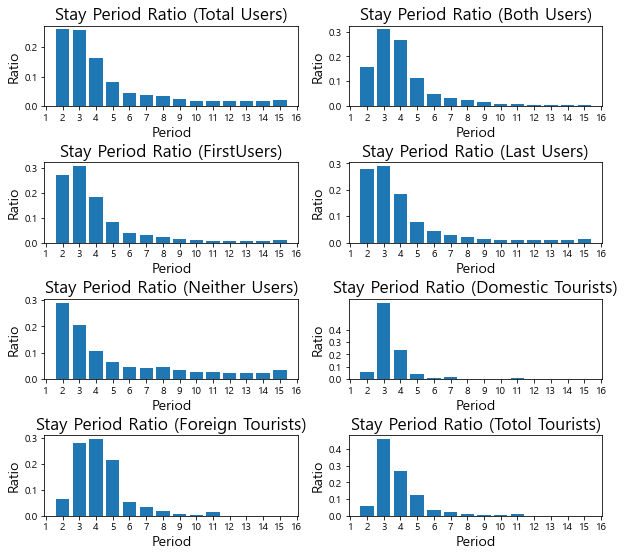

In [176]:
df = merged_stay_period_df

y_columns = list(df.columns)
y_columns.remove("period")

titles = ["Stay Period Ratio (Total Users)",
         "Stay Period Ratio (Both Users)",
         "Stay Period Ratio (First Users)",
         "Stay Period Ratio (Last Users)",
         "Stay Period Ratio (Neither Users)",
         "Stay Period Ratio (Domestic Tourists)",
         "Stay Period Ratio (Foreign Tourists)",
         "Stay Period Ratio (Totol Tourists)"]

plt.figure(figsize=(10, 18))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.7)
draw_bar_graph_from_df_by_all_columns(merged_stay_period_df, "period", y_columns, titles, "Period", "Ratio")

### 4-2-6) 출입정류장 이용 유형별 체류기간 분포도 유사성 분석

In [42]:
# 두 분포도의 유사성 계산
def how_much_overlap(df, a_column, b_column):
    df = df.copy()
    df["min"] = df[[a_column, b_column]].apply(lambda x : x[0] if x[0] < x[1] else x[1], axis = 1)
    return df["min"].sum()

# 전체 이용자 및 4가지 유형별 이용자에 대한 유사도 계산 및 출력
type_list = ["total_user", "both_user", "first_user", "last_user", "neither_user"]

for i, t in enumerate(type_list):
    intersector_ratio = how_much_overlap(merged_stay_period_df, "total_tourist", t)
    print("%12s intersection ratio = %f.3"% (t, intersector_ratio));

  total_user intersection ratio = 0.647093.3
   both_user intersection ratio = 0.829434.3
  first_user intersection ratio = 0.718184.3
   last_user intersection ratio = 0.695458.3
neither_user intersection ratio = 0.525170.3


## 4-3) 관광정류장 방문 횟수 특성 검증

### 4-3-1) 관광정류장 방문 횟수별 이용자 수

In [187]:
bus_count_df = get_count_df(user_df, "tour_count", "count")
print(bus_count_df["count"].sum())
bus_count_df[bus_count_df["tour_count"] < 6]["count"].sum()/bus_count_df["count"].sum()
bus_count_df[bus_count_df["tour_count"] == 5]["count"].sum()/bus_count_df["count"].sum()

726192


0.03897178707559433

### 4-3-2) 관광정류장 방문 횟수별 체류기간 분포도 생성

In [188]:
df = user_df
df = df[(2<=df["period"]) & (df["period"]<=15)]

df_list = []
target_column = "period"
result_columns = []
term = 1

# max_tour_count = bus_count_df[bus_count_df["count"]>200]["tour_count"].max()
max_tour_count = 5

# for i in range(0, max_tour_count, term):
#     df_list.append(df[(i <= df["tour_count"]) & (df["tour_count"] < i+term)])
#     result_columns.append(str(i)+"~"+str(i+term-1))

for i in range(0, max_tour_count+1, term):
    df_list.append(df[i <= df["tour_count"]])
    result_columns.append("count = "+str(i))               
                  
                  
bus_stay_period_df = get_ratio_df_from_all_df(df_list, target_column, result_columns)
bus_stay_period_df

,period,count = 0,count = 1,count = 2,count = 3,count = 4,count = 5
0,2,0.260355,0.260192,0.240203,0.205465,0.167177,0.131600
1,3,0.258329,0.286039,0.302655,0.313260,0.314874,0.304626
2,4,0.162844,0.179888,0.196847,0.220826,0.240558,0.256772
3,5,0.080301,0.081778,0.088606,0.099809,0.112261,0.127155
4,6,0.045565,0.042536,0.043323,0.046317,0.051868,0.059382
5,7,0.035526,0.031597,0.030549,0.031344,0.034356,0.039356
6,8,0.033494,0.026089,0.022974,0.021197,0.022005,0.024973
7,9,0.022719,0.017697,0.015000,0.013223,0.012971,0.013402
8,10,0.018072,0.013747,0.011354,0.009571,0.009478,0.010155
9,11,0.016416,0.012407,0.010366,0.008725,0.008335,0.008150


### 4-3-3) 제주와 버스데이터의  관광정류장 방문 횟수별 체류기간 비율 분포 병합

In [189]:
# 통계 데이터와 병합
merged_stay_period_df = pd.merge(bus_stay_period_df, jeju_stay_period_df, on="period", how="inner")
merged_stay_period_df

,period,count = 0,count = 1,count = 2,count = 3,count = 4,count = 5,domestic_tourist,foreign_tourist,total_tourist
0,2,0.260355,0.260192,0.240203,0.205465,0.167177,0.131600,0.057,0.066,0.061253
1,3,0.258329,0.286039,0.302655,0.313260,0.314874,0.304626,0.618,0.280,0.458272
2,4,0.162844,0.179888,0.196847,0.220826,0.240558,0.256772,0.238,0.296,0.265409
3,5,0.080301,0.081778,0.088606,0.099809,0.112261,0.127155,0.045,0.217,0.126282
4,6,0.045565,0.042536,0.043323,0.046317,0.051868,0.059382,0.013,0.055,0.032848
5,7,0.035526,0.031597,0.030549,0.031344,0.034356,0.039356,0.015,0.035,0.024451
6,8,0.033494,0.026089,0.022974,0.021197,0.022005,0.024973,0.003,0.019,0.010561
7,9,0.022719,0.017697,0.015000,0.013223,0.012971,0.013402,0.001,0.006,0.003363
8,10,0.018072,0.013747,0.011354,0.009571,0.009478,0.010155,0.001,0.004,0.002418
9,11,0.016416,0.012407,0.010366,0.008725,0.008335,0.008150,0.006,0.016,0.010726


### 4-3-4) 관광정류장 방문 횟수별 체류기간 분포도 분석

In [190]:
merged_stay_period_stats_df = get_stats_df_from_ratio_df_by_all_columns(merged_stay_period_df, "period")
merged_stay_period_stats_df

,mean,variancd,std_divation
count = 0,4.608678,83.891322,9.159221
count = 1,4.277513,84.222487,9.177281
count = 2,4.156398,84.343602,9.183877
count = 3,4.120242,84.379758,9.185846
count = 4,4.186388,84.313612,9.182244
count = 5,4.312864,84.187136,9.175355
domestic_tourist,3.437000,85.063000,9.222960
foreign_tourist,4.238000,84.262000,9.179434
total_tourist,3.815528,84.684472,9.202417


### 4-3-5) 관광정류장 방문 횟수별 체류기간 분포도 그래프

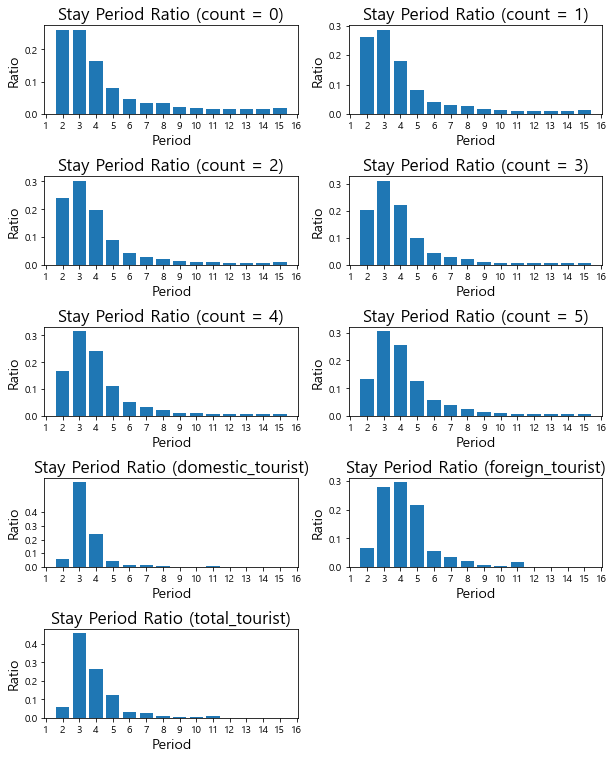

In [193]:
# df에서 x와 y속성을 넘기면 해당 데이터에 대한 막대그래프을 생성하여 반환
def draw_bar_graph_from_df_by_one_column(df, x_column, y_column, title, x_label, y_label):
    df = df[[x_column, y_column]]
    x = df[x_column]
    y = df[y_column]
    plt.title(title, fontsize=17)
    plt.xlabel(x_label, fontsize = 14)
    plt.ylabel(y_label, fontsize = 14)
    return plt.bar(x, y)

# df에서 x와 y속성들에 대한 막대그래프를 생성하여 반환
def draw_bar_graph_from_df_by_all_columns(df, x_column, y_columns, titles, x_label, y_label):
    n = len(y_columns)
    for i in range(n):
        plt.subplot(n, 2, i+1)
        plt.xticks(np.arange(0, 17, 1))
        plt.yticks(np.arange(0, 0.5, 0.1))
        draw_bar_graph_from_df_by_one_column(df, x_column, y_columns[i], titles[i], x_label, y_label)

        jeju_stay_period_df


df = merged_stay_period_df

y_columns = list(df.columns)
y_columns.remove("period")

titles = pd.Series(y_columns).apply(lambda x : "Stay Period Ratio (%s)"%x)

plt.figure(figsize=(10, 20))
plt.subplots_adjust(left=0.125, bottom=0.0, right=0.9, top=0.9, wspace=0.2, hspace=0.7)
draw_bar_graph_from_df_by_all_columns(df, "period", y_columns, titles, "Period", "Ratio")
plt.savefig("ccc.svg")

### 4-3-6) 관광정류장 방문 횟수별 체류기간 분포도 유사성 분석

In [48]:
# 전체 이용자 및 4가지 유형별 이용자에 대한 유사도 계산 및 출력
type_list = list(merged_stay_period_df.columns)
remove_elements = ["period", "domestic_tourist", "foreign_tourist", "total_tourist"]
for element in remove_elements:
    type_list.remove(element)
    
for i, t in enumerate(type_list):
    intersector_ratio = how_much_overlap(merged_stay_period_df, "total_tourist", t)
    print("%13s intersection ratio = %.3f"% (t, intersector_ratio));

    count = 0 intersection ratio = 0.647
    count = 1 intersection ratio = 0.693
    count = 2 intersection ratio = 0.733
    count = 3 intersection ratio = 0.778
    count = 4 intersection ratio = 0.811
    count = 5 intersection ratio = 0.831


### 4-3-7) 추가 분석(기타)

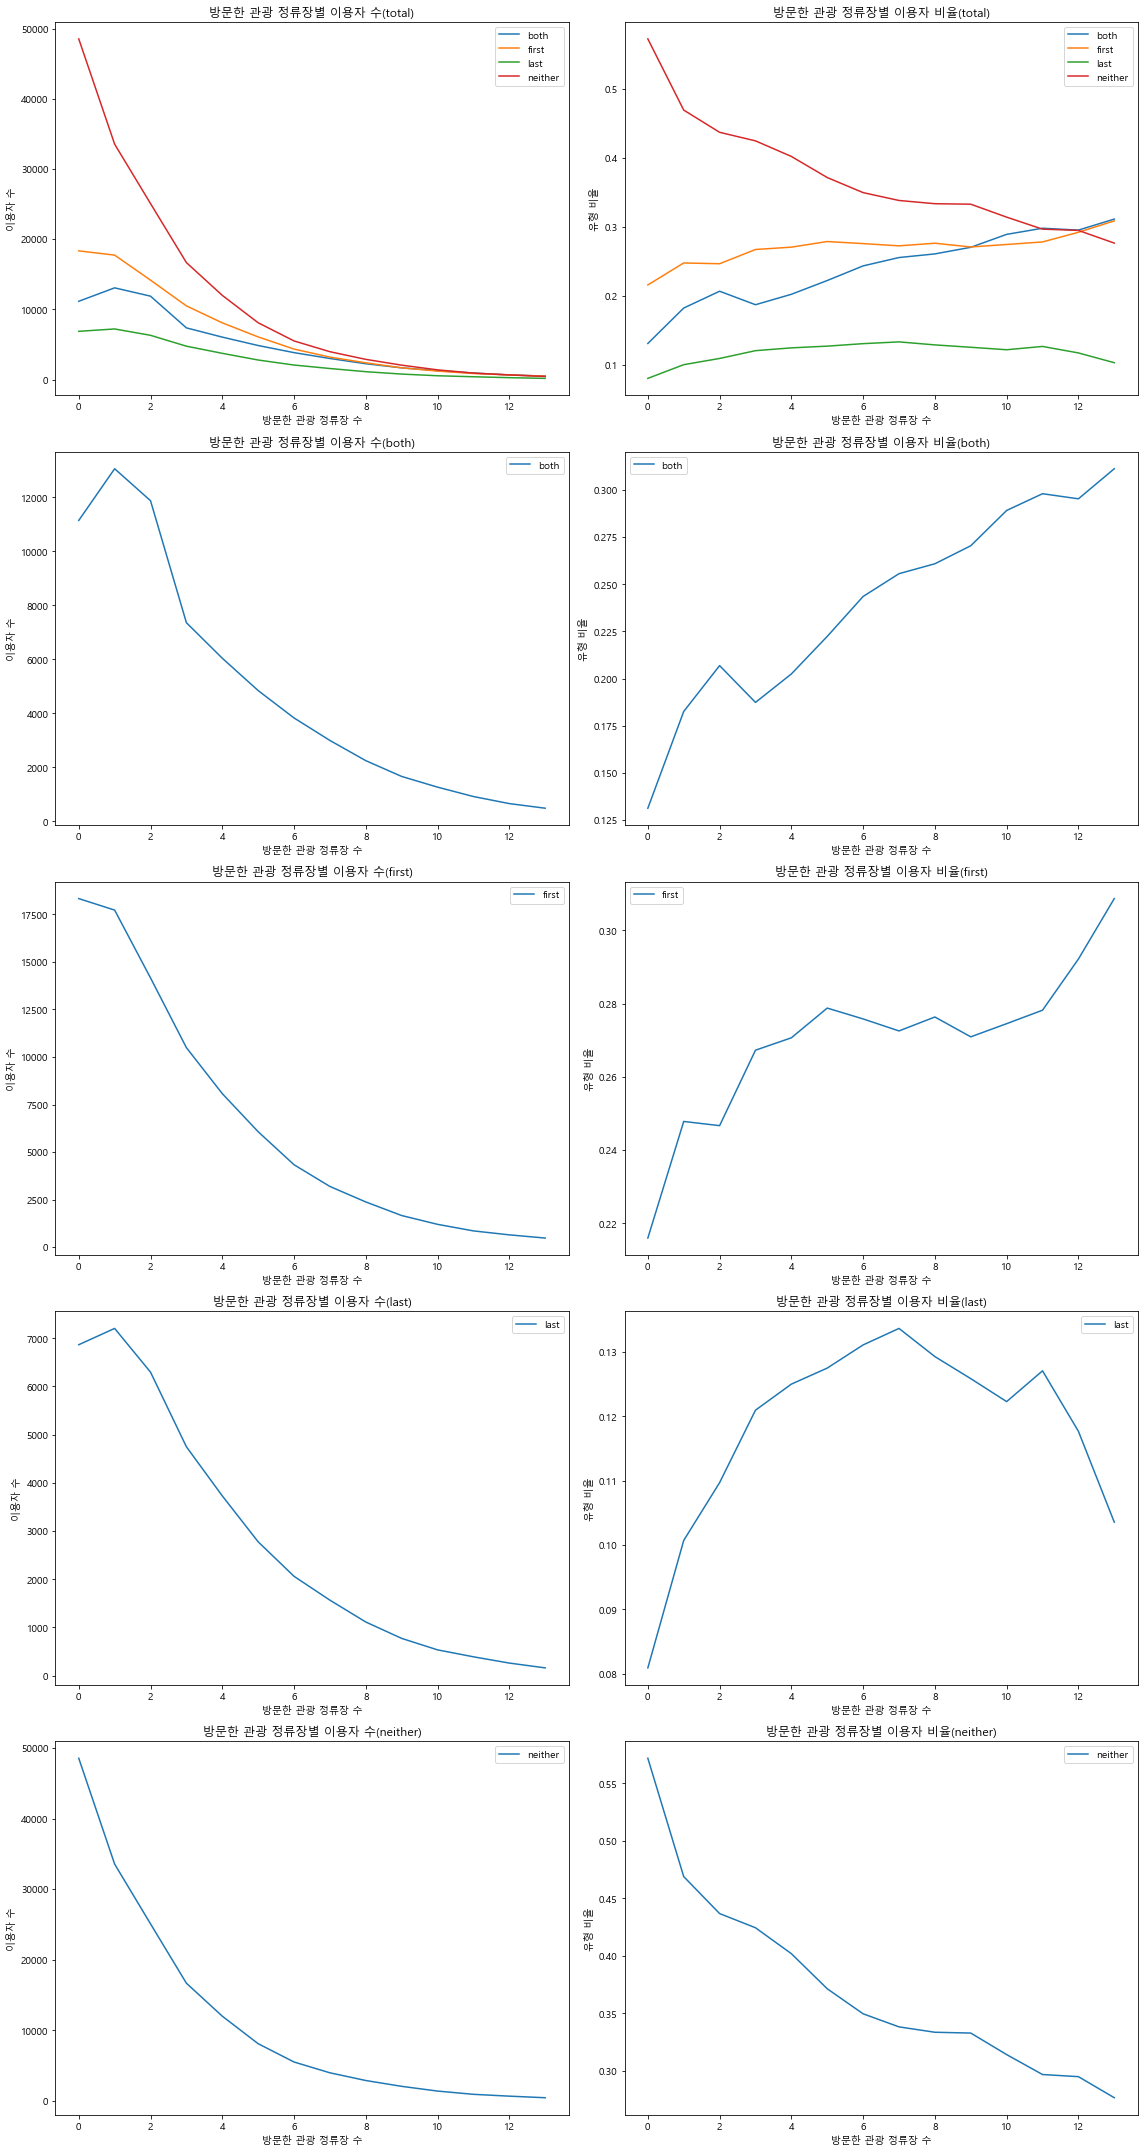

In [49]:
def draw_tour_visit_analysis_graph(user_df):
    # 데이터 분석
    columns = ['both', 'first', 'last', 'neither']
    ratio_values = {}
    count_values = {}
    for column in columns:
        count_values[column] = []
        ratio_values[column] = []

    max_visit = int(user_df["tour_count"].max())
    for i in range(max_visit):
        sample_df = user_df[(i <=user_df["tour_count"]) & (user_df["tour_count"] <= i+1)]
        total_count = len(sample_df)
        for column in columns:
            count = len(sample_df[sample_df["case"] == column])
            count_values[column].append(count)
            ratio_values[column].append(count/total_count)
    
    # 그래프 그리기
    plt.figure(figsize=(16, 30))
    
    # 그래프 - 전체 그래프
    plt.subplot(5, 2, 1)
    for idx, column in enumerate(columns):
        plt.plot(list(range(0, max_visit, 1)), count_values[column])
        plt.legend(columns, loc = 0)
        plt.title('방문한 관광 정류장별 이용자 수({})'.format("total"))
        plt.xlabel("방문한 관광 정류장 수")
        plt.ylabel("이용자 수") 
        
    # 그래프 - 유형별 그래프
    plt.subplot(5, 2, 2)
    for idx, column in enumerate(columns):
        plt.plot(list(range(0, max_visit, 1)), ratio_values[column])
        plt.legend(columns, loc = 0)
        plt.title('방문한 관광 정류장별 이용자 비율({})'.format("total"))
        plt.xlabel("방문한 관광 정류장 수")
        plt.ylabel("유형 비율")
        
    for idx, column in enumerate(columns):
        
        plt.subplot(5, 2, 2*(idx)+3)
        plt.plot(list(range(0, max_visit, 1)), count_values[column])
        plt.legend([columns[idx]], loc = 0)
        plt.title('방문한 관광 정류장별 이용자 수({})'.format(column))
        plt.xlabel("방문한 관광 정류장 수")
        plt.ylabel("이용자 수")

        plt.subplot(5, 2, 2*(idx)+4)
        plt.plot(list(range(0, max_visit, 1)), ratio_values[column])
        plt.legend([columns[idx]], loc = 0)
        plt.title('방문한 관광 정류장별 이용자 비율({})'.format(column))
        plt.xlabel("방문한 관광 정류장 수")
        plt.ylabel("유형 비율")
    plt.tight_layout() 
    return plt

df = user_df
df = df[(2<=df["period"]) & (df["period"]<=15)] # 통계 자료가 보여주는 체류기간 내에서만 분석한다.
df = df[df["tour_count"]<15] # 방문 횟수가 15회를 넘어가면 이용자 수가 매우 적어 노이즈가 될 수 있다.
plt = draw_tour_visit_analysis_graph(df)
plt.show()

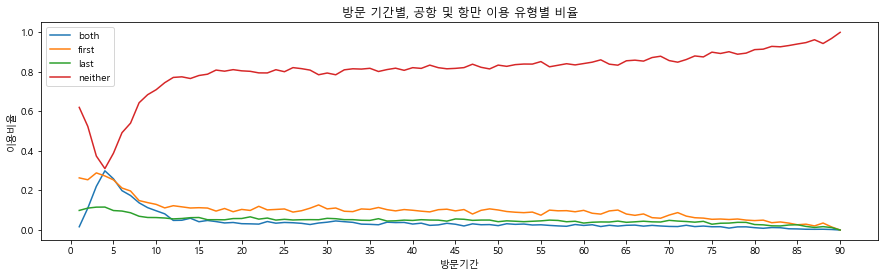

In [50]:
def draw_period_analysis_graph(user_df):
    wedgeprops={'width': 0.65, 'edgecolor': 'w', 'linewidth': 5}

    columns = ['both', 'first', 'last', 'neither']
    values = [[], [], [], []]
    period = 90
    term = 1
    for period in list(range(1, period+1, term)):
        user_df2 = user_df[(period-1 < user_df['period']) & (user_df['period'] <= period)]
        for i in range(4):
            sum = len(user_df2)
            values[i].append(len(user_df2[user_df2["case"] == columns[i]])/sum)

    plt.rcParams["figure.figsize"] = (15,4)
    for i in list(range(4)):
        plt.plot(list(range(1, period+1, term)), values[i])

    plt.legend(columns)
    plt.title('방문 기간별, 공항 및 항만 이용 유형별 비율')
    plt.xlabel("방문기간")
    plt.ylabel("이용비율")
    plt.xticks(list(range(0, period+1, 5)))
    plt.show()
    return plt


plt = draw_period_analysis_graph(user_df)
plt.show()

## 4-4) 관광객의 대중교통 이용비율 특성 검증

### 4-4-1) 대중교통 이용 비율 별 이용자 수

In [51]:
df = user_df
df = df[(2<=df["period"]) & (df["period"]<=15)]
get_count_df(df, "usage_ratio", "ratio")

,usage_ratio,ratio
0,13,1414
1,14,1081
2,15,965
3,16,962
4,18,1078
5,20,2230
6,21,622
7,22,1581
8,23,664
9,25,3172


### 4-4-2) 대중교통 이용 비율 별 체류기간 분포도 생성

In [52]:
df = user_df
df = df[(2<=df["period"]) & (df["period"]<=15)]

df_list = []
target_column = "period"
result_columns = []
term = 10

# for i in range(0, 100, term):
#     df_list.append(df[(i < df["usage_ratio"]) & (df["usage_ratio"] <= i+term)])
#     result_columns.append(str(i)+"~"+str(i+term-1))

for i in range(0, 100, term):
    df_list.append(df[i <= df["usage_ratio"]])
    result_columns.append(str(i)+"~")               
                  
bus_stay_period_df = get_ratio_df_from_all_df(df_list, target_column, result_columns)
bus_stay_period_df

,period,0~,10~,20~,30~,40~,50~,60~,70~,80~,90~
0,2,0.260355,0.260355,0.267522,0.284892,0.298049,0.312702,0.341811,0.411829,0.451004,0.479875
1,3,0.258329,0.258329,0.265440,0.282675,0.295730,0.310268,0.339151,0.255790,0.280122,0.298054
2,4,0.162844,0.162844,0.167327,0.178191,0.186420,0.195585,0.155736,0.187638,0.132741,0.141238
3,5,0.080301,0.080301,0.082512,0.087869,0.091928,0.069283,0.075732,0.067244,0.073640,0.046625
4,6,0.045565,0.045565,0.046819,0.049859,0.034959,0.036677,0.029559,0.024819,0.027179,0.015811
5,7,0.035526,0.035526,0.036504,0.026363,0.027581,0.021056,0.016583,0.019980,0.014522,0.007712
6,8,0.033494,0.033494,0.034416,0.023251,0.016969,0.017803,0.014178,0.011273,0.007021,0.003385
7,9,0.022719,0.022719,0.023345,0.016433,0.011638,0.008858,0.006958,0.005517,0.003375,0.001490
8,10,0.018072,0.018072,0.018570,0.013112,0.009525,0.007214,0.005711,0.004854,0.003468,0.002002
9,11,0.016416,0.016416,0.011472,0.008720,0.006625,0.005365,0.004355,0.003891,0.002683,0.001589


### 4-4-3) 제주와 버스데이터의  대중교통 이용 비율 별 체류기간 비율 분포 병합

In [53]:
# 통계 데이터와 병합
merged_stay_period_df = pd.merge(bus_stay_period_df, jeju_stay_period_df, on="period", how="inner")
merged_stay_period_df

,period,0~,10~,20~,30~,40~,50~,60~,70~,80~,90~,domestic_tourist,foreign_tourist,total_tourist
0,2,0.260355,0.260355,0.267522,0.284892,0.298049,0.312702,0.341811,0.411829,0.451004,0.479875,0.057,0.066,0.061253
1,3,0.258329,0.258329,0.265440,0.282675,0.295730,0.310268,0.339151,0.255790,0.280122,0.298054,0.618,0.280,0.458272
2,4,0.162844,0.162844,0.167327,0.178191,0.186420,0.195585,0.155736,0.187638,0.132741,0.141238,0.238,0.296,0.265409
3,5,0.080301,0.080301,0.082512,0.087869,0.091928,0.069283,0.075732,0.067244,0.073640,0.046625,0.045,0.217,0.126282
4,6,0.045565,0.045565,0.046819,0.049859,0.034959,0.036677,0.029559,0.024819,0.027179,0.015811,0.013,0.055,0.032848
5,7,0.035526,0.035526,0.036504,0.026363,0.027581,0.021056,0.016583,0.019980,0.014522,0.007712,0.015,0.035,0.024451
6,8,0.033494,0.033494,0.034416,0.023251,0.016969,0.017803,0.014178,0.011273,0.007021,0.003385,0.003,0.019,0.010561
7,9,0.022719,0.022719,0.023345,0.016433,0.011638,0.008858,0.006958,0.005517,0.003375,0.001490,0.001,0.006,0.003363
8,10,0.018072,0.018072,0.018570,0.013112,0.009525,0.007214,0.005711,0.004854,0.003468,0.002002,0.001,0.004,0.002418
9,11,0.016416,0.016416,0.011472,0.008720,0.006625,0.005365,0.004355,0.003891,0.002683,0.001589,0.006,0.016,0.010726


### 4-4-4) 대중교통 이용 비율 별 체류기간 분포도 분석

In [54]:
merged_stay_period_stats_df = get_stats_df_from_ratio_df_by_all_columns(merged_stay_period_df, "period")
merged_stay_period_stats_df

,mean,variancd,std_divation
0~,4.608678,83.891322,9.159221
10~,4.608678,83.891322,9.159221
20~,4.373714,84.126286,9.172038
30~,3.998561,84.501439,9.192466
40~,3.776547,84.723453,9.204534
50~,3.607823,84.892177,9.213695
60~,3.414179,85.085821,9.224198
70~,3.293169,85.206831,9.230755
80~,3.113401,85.386599,9.240487
90~,2.907945,85.592055,9.251597


### 4-3-5) 대중교통 이용 비율 별 체류기간 분포도 그래프

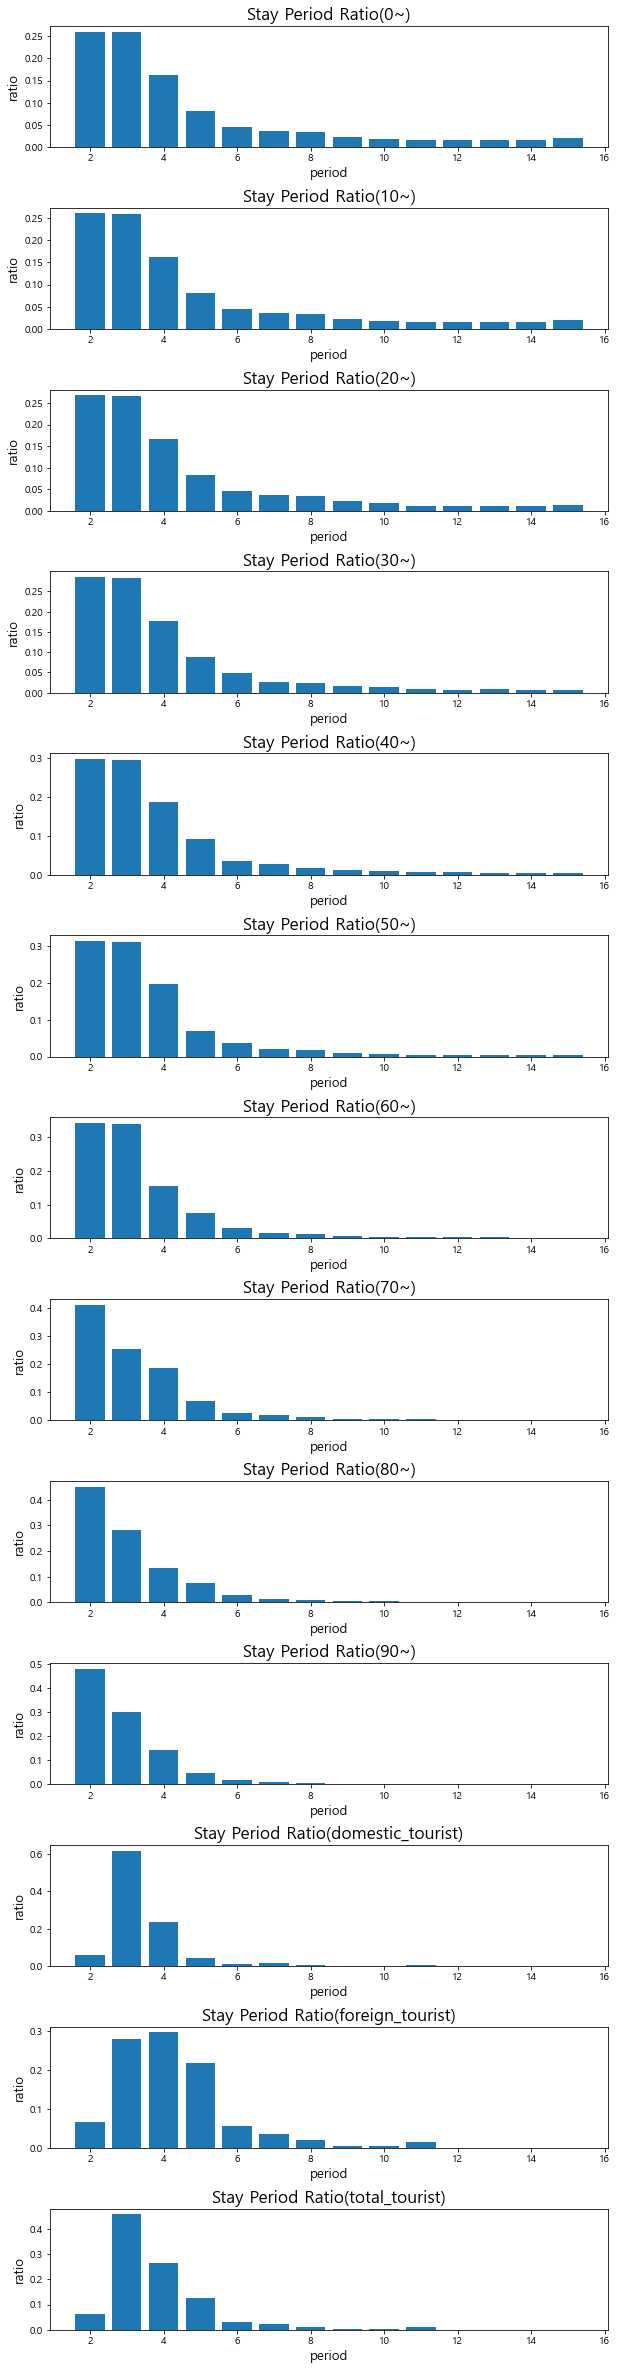

In [55]:
df = merged_stay_period_df

y_columns = list(df.columns)
y_columns.remove("period")

titles = pd.Series(y_columns).apply(lambda x : "Stay Period Ratio(%s)"%x)

plt.figure(figsize=(10, 40))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
draw_bar_graph_from_df_by_all_columns(df, "period", y_columns, titles, "period", "ratio")

### 4-4-6) 대중교통 이용 비율 별 체류기간 분포도 유사성 분석

In [56]:
# 전체 이용자 및 4가지 유형별 이용자에 대한 유사도 계산 및 출력
type_list = list(merged_stay_period_df.columns)
remove_elements = ["period", "domestic_tourist", "foreign_tourist", "total_tourist"]
for element in remove_elements:
    type_list.remove(element)
    
for i, t in enumerate(type_list):
    intersector_ratio = how_much_overlap(merged_stay_period_df, "total_tourist", t)
    print("%12s intersection ratio = %f.3"% (t, intersector_ratio));

          0~ intersection ratio = 0.647093.3
         10~ intersection ratio = 0.647093.3
         20~ intersection ratio = 0.660898.3
         30~ intersection ratio = 0.692349.3
         40~ intersection ratio = 0.715596.3
         50~ intersection ratio = 0.712000.3
         60~ intersection ratio = 0.698710.3
         70~ intersection ratio = 0.636956.3
         80~ intersection ratio = 0.604942.3
         90~ intersection ratio = 0.579160.3


# 5. 하이퍼파라미터 튜닝

## 5-1) 튜닝 데이터 생성

In [57]:
# get_tuning_df()에서 모든 경우의 수에 대해 1번씩 호출되는 함수
# 제주 체류시간 통계자료와의 유사도를 반환
def func(df):
    ration_df = get_ratio_df_from_one_df(df, "period", "ratio")
    merged_stay_period_df = pd.merge(ration_df, jeju_stay_period_df, on="period", how="inner")
    result = 0
    try:
        result = how_much_overlap(merged_stay_period_df, "total_tourist", "ratio")
    finally:
        return result

def get_tuning_df(df, orders, func, result_column):
    column = orders[0]["column"]
    result_df_list = []
    if len(orders) == 1:
        if "values" in orders[0].keys():
            for value in orders[0]["values"]:
                target_df = df[df[column] == value]
                result = func(target_df)
                result_df = pd.DataFrame(columns=[column, result_column])
                result_df.loc[0] = [value, result]
                result_df_list.append(result_df)
        else:
            for r in orders[0]["ranges"]:
                target_df = df[(r[0] <= df[column]) & (df[column] < r[1])]
                result = func(target_df)
                result_df = pd.DataFrame(columns=[column, result_column])
                result_df.loc[0] = ["(%d, %d)"%(r[0], r[1]), result]
                result_df_list.append(result_df)
    elif len(orders) > 1:
        if "values" in orders[0].keys():
            for value in orders[0]["values"]:
                target_df = df[df[column] == value]
                result_df = get_tuning_df(target_df, orders[1:], func, result_column)
                result_df[column] = value
                result_df_list.append(result_df)
        else:
            for r in orders[0]["ranges"]:
                target_df = df[(r[0] <= df[column]) & (df[column] < r[1])]
                result_df = get_tuning_df(target_df, orders[1:], func, result_column)
                result_df[column] = "(%d, %d)"%(r[0], r[1])
                result_df_list.append(result_df)
                
    # 결과 df병합
    result_df = pd.concat(result_df_list)
    
    # 컬럼 순서 재배치
    columns = list(result_df.columns)
    columns.remove(column)
    columns = [column]+columns
    
    result_df.reset_index(inplace=True)
    del result_df["index"]
    return result_df[columns]    

ranges = []
for i in range(0, 20, 1):
    ranges.append((i, 20))
    
orders = [{"column":"case", "values":["both", "first", "last", "neither"]},
          {"column":"tour_count", "ranges":ranges}]

result_column = "similarity"

tuning_df = get_tuning_df(user_df, orders, func, result_column)

## 5-2) 튜닝 데이터 분석

In [58]:
tuning_df[tuning_df["case"] == "neither"]

,case,tour_count,similarity
60,neither,"(0, 20)",0.173146
61,neither,"(1, 20)",0.189464
62,neither,"(2, 20)",0.209542
63,neither,"(3, 20)",0.224230
64,neither,"(4, 20)",0.239066
65,neither,"(5, 20)",0.247682
66,neither,"(6, 20)",0.245802
67,neither,"(7, 20)",0.244959
68,neither,"(8, 20)",0.239519
69,neither,"(9, 20)",0.231897


In [59]:
case_list = ["both", "first", "last", "neither"]

result_df = pd.DataFrame(columns=["tour_count"])

for case in case_list:
    df = tuning_df[tuning_df["case"] == case]
    df = df[["tour_count", "similarity"]]
    df["similarity"] = df["similarity"].apply(lambda x : "%.2f"%x)
    df = df.rename(columns={"similarity":case})
    result_df = pd.merge(result_df, df, on="tour_count", how="outer")
result_df

,tour_count,both,first,last,neither
0,"(0, 20)",0.69,0.33,0.32,0.17
1,"(1, 20)",0.75,0.46,0.39,0.19
2,"(2, 20)",0.78,0.60,0.55,0.21
3,"(3, 20)",0.81,0.67,0.62,0.22
4,"(4, 20)",0.79,0.71,0.67,0.24
5,"(5, 20)",0.76,0.73,0.70,0.25
6,"(6, 20)",0.74,0.72,0.69,0.25
7,"(7, 20)",0.70,0.68,0.67,0.24
8,"(8, 20)",0.67,0.64,0.63,0.24
9,"(9, 20)",0.64,0.59,0.59,0.23


# 6. 결과 출력 

## 6-1) 데이터 출력

### 6-1-1) 이용자 출력

In [60]:
user_df

,user_id,first_date,last_date,use_days,period,usage,usage_ratio,first,last,case,airport_count,harbor_count,access_count,tour_count,tourist
0,f6f372cf8c6732eafc2a82b4f9d7a08bb3b493213ea4ef...,2019-06-01,2019-06-09,5,9,14,55,other,other,neither,1,0,1,2,False
1,3f6cfe2429f6e8d62cddc39222993405789b7b9ea2a592...,2019-06-01,2019-08-28,26,89,59,29,other,other,neither,1,0,1,4,False
2,107cd874732b48a35df957bf653751154b0234e5573ba5...,2019-06-01,2019-08-28,63,89,249,70,other,other,neither,0,0,0,2,False
3,27b16001fafd812b1e5c474cbc60455a9286ad27ecf8e5...,2019-06-01,2019-08-28,47,89,83,52,other,other,neither,0,0,0,4,False
4,89c9a1c6e5915df4c192acc54067ee9a743f44eb559f3b...,2019-06-01,2019-08-28,26,89,35,29,other,other,neither,0,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726187,1c0b23153f52f11215e7d1f4e45dcecfa6d669676c4a9f...,2019-08-28,2019-08-28,1,1,1,100,other,other,neither,0,0,0,0,False
726188,8235b6d43ba2e06d89fe94fda0dfdb7b4fe678ac58eaf5...,2019-08-28,2019-08-28,1,1,1,100,other,other,neither,0,0,0,0,False
726189,f6f259fe96fd2e245be452a154c7c43ac747bc0f5d5ad1...,2019-08-29,2019-08-29,1,1,1,100,other,no_tag,neither,0,0,0,0,False
726190,670048e0bb0ed87661ef4e33fe476d74e4616c137bcdb0...,2019-08-29,2019-08-29,1,1,1,100,other,other,neither,0,0,0,0,False


### 6-1-2) 정류장 출력

In [61]:
station_df

,station_id,station_name,station_longitude,station_latitude,station_address,total_geton,total_getoff,airport_flag,harbor_flag,tour_station_flag,tourist_geton_count,tourist_getoff_count
0,988.0,납읍리사무소,126.32944,33.43944,제주특별자치도 제주시 애월읍 납읍리 1754-3,3209,527,False,False,False,29.0,1.0
1,26.0,하귀초등학교,126.40212,33.48017,제주특별자치도 제주시 애월읍 하귀2리 1908-2,26344,12598,False,False,False,1043.0,748.0
2,3271.0,제주시청(광양방면),126.53035,33.49892,제주특별자치도 제주시 이도이동 1938-1,243695,145122,False,False,False,5187.0,3689.0
3,342.0,삼무공원,126.49240,33.48980,제주특별자치도 제주시 연동 281,14776,5635,False,False,False,3605.0,409.0
4,638.0,제주국제공항(구제주방면),126.49345,33.50661,제주특별자치도 제주시 용담이동 1462-1,142233,55880,True,False,False,19307.0,8281.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3649,2213.0,수산1리비석거리,126.88861,33.44354,제주특별자치도 서귀포시 성산읍 수산리 269,False,False,False,False,False,0.0,0.0
3650,2972.0,제주국제공항(종점),126.49356,33.50572,제주특별자치도 제주시 용담이동 1462,7566,742,True,False,False,936.0,25326.0
3651,2279.0,하모3리축협,126.25240,33.22531,제주특별자치도 서귀포시 대정읍 하모리 1423-20,678,389,False,False,False,333.0,514.0
3652,3350.0,"제주국제공항(평화로,800번)",126.49272,33.50636,제주특별자치도 제주시 용담이동 2002,1551,1740,True,False,False,2495.0,104.0


## 6-2) 관광객 출력

### 6-2-1) 방문기간 별 관광객 수 출력

<module 'matplotlib.pyplot' from 'C:\\Users\\hooni\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

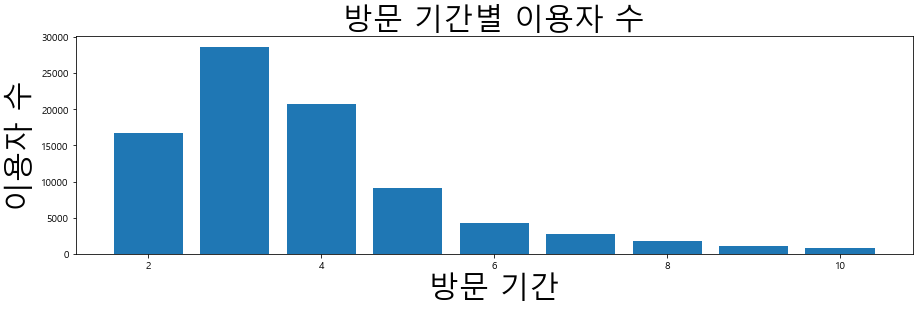

In [62]:
def draw_period_user(plt, user_df, title=""):
    data = user_df['period'].value_counts().reset_index().sort_values('index')
    data_x = data['index']
    data_y = data['period']
    
    plt.bar(data_x, data_y)
    if title == "":
        plt.title('방문 기간별 이용자 수', fontsize=30)
    else:
        plt.title(title, fontsize=30)
    plt.xlabel('방문 기간', fontsize = 30)
    plt.ylabel('이용자 수', fontsize = 30)
    return plt

df = user_df[user_df["tourist"] == True]
draw_period_user(plt, df)

### 6-2-2) both 관광객 출력

In [63]:
def show_od_pattern(user_df, usage_df, num):
    id = user_df.iloc[num, 0]
    print("id = %s"%id)
    select = ["base_date", "geton_datetime", "geton_stataion_name", "getoff_datetime", "getoff_station_name"]
    od_df = usage_df.query('user_id == "{}"'.format(id)).sort_values('geton_datetime')
    return od_df[select]

df = user_df[user_df["tourist"] & (user_df["case"] == "both")]
show_od_pattern(df, usage_df, 100)

id = a9e2c88623fed9140eb78b2f0777dfac4d88d7b26f70656ef673822347ca8f65


,base_date,geton_datetime,geton_stataion_name,getoff_datetime,getoff_station_name
82469,20190601,2019-06-01 14:49:40,"제주국제공항(대정,화순,일주서로)",2019-06-01 15:05:25,월랑마을남녕고등학교
82470,20190601,2019-06-01 15:18:53,원노형,2019-06-01 15:36:34,제주도립미술관
82471,20190601,2019-06-01 17:43:16,제주도립미술관입구,2019-06-01 18:31:08,탐라장애인종합복지관
216128,20190602,2019-06-02 06:34:42,제주버스터미널,2019-06-02 06:42:58,제주국제공항(신제주방면)


### 6-2-3) first 관광객 출력

In [64]:
df = user_df[user_df["tourist"] & (user_df["case"] == "first")]
show_od_pattern(df, usage_df, 100)

id = 0b9966bf7cd3f42fe557441d1746d772145b608aecc20b1726a9fe5e0785efe7


,base_date,geton_datetime,geton_stataion_name,getoff_datetime,getoff_station_name
77451,20190601,2019-06-01 07:39:23,"제주국제공항(평화로,800번)",2019-06-01 07:55:50,연동365의원
77450,20190601,2019-06-01 13:23:28,제원아파트,2019-06-01 13:40:42,한국병원
77453,20190601,2019-06-01 13:52:59,한국병원,2019-06-01 14:54:17,월정리
77452,20190601,2019-06-01 18:07:27,월정리용천동,2019-06-01 19:11:07,제주버스터미널(종점)
77449,20190601,2019-06-01 19:40:46,제주버스터미널,2019-06-01 19:51:00,삼무공원
132567,20190602,2019-06-02 08:16:38,도호동,2019-06-02 08:27:51,제주버스터미널
132566,20190602,2019-06-02 08:45:06,제주버스터미널,2019-06-02 09:49:53,성산항
132568,20190602,2019-06-02 17:19:07,성산리,2019-06-02 19:02:01,제주버스터미널(종점)
132569,20190602,2019-06-02 19:33:22,제주버스터미널,2019-06-02 19:45:07,연동주민센터
244334,20190603,2019-06-03 10:00:00,신제주초등학교,NaT,NaN


### 6-2-4) last 관광객 출력

In [65]:
df = user_df[user_df["tourist"] & (user_df["case"] == "last")]
show_od_pattern(df, usage_df, 100)

id = d78f86c32ddf4135994c4aaa73ba4169f063b7bf6f79a65c1d5a62576e4565dc


,base_date,geton_datetime,geton_stataion_name,getoff_datetime,getoff_station_name
18370,20190601,2019-06-01 13:21:10,월정리,NaT,NaN
355412,20190603,2019-06-03 14:41:41,제주국제공항,2019-06-03 15:51:29,성산환승정류장(고성리회전교차로)
556563,20190604,2019-06-04 12:39:51,고성리구성산농협,2019-06-04 13:58:32,제주버스터미널(종점)
556562,20190604,2019-06-04 14:27:19,제주버스터미널,NaT,NaN
611355,20190605,2019-06-05 16:08:57,제주시청(광양방면),NaT,NaN
611356,20190605,2019-06-05 17:17:30,제주중학교/제주향교,NaT,NaN
611354,20190605,2019-06-05 19:59:46,북촌리해동,NaT,NaN
960691,20190607,2019-06-07 11:41:32,구좌중앙초등학교,2019-06-07 11:43:54,월정리
960690,20190607,2019-06-07 11:46:11,김녕환승정류장(김녕초등학교),2019-06-07 12:46:44,제주국제공항(종점)


### 6-2-5) neither 관광객 출력

In [66]:
df = user_df[user_df["tourist"] & (user_df["case"] == "neither")]
show_od_pattern(df, usage_df, 3)

id = d6b3bc2a0df0119d05cca64707bb47763094737632abd4f35ba46acc09130a8e


,base_date,geton_datetime,geton_stataion_name,getoff_datetime,getoff_station_name
673,20190601,2019-06-01 09:12:11,(구)중문동주민센터,2019-06-01 09:34:16,서귀포시구시외버스터미널
674,20190601,2019-06-01 10:10:23,중앙로터리(동),2019-06-01 10:23:20,돈내코
672,20190601,2019-06-01 12:23:16,서귀포산업과학고등학교,2019-06-01 12:29:45,한라산둘레길
675,20190601,2019-06-01 17:43:51,충혼묘지광장,2019-06-01 18:26:35,중앙로터리
671,20190601,2019-06-01 18:31:24,중앙로터리,2019-06-01 19:02:13,중문초등학교
199886,20190602,2019-06-02 08:53:18,(구)중문동주민센터,2019-06-02 09:58:01,남원포구입구
199885,20190602,2019-06-02 10:05:14,남원포구입구,NaT,NaN
199887,20190602,2019-06-02 17:36:42,사농동산,2019-06-02 17:51:05,남원1리사무소
199888,20190602,2019-06-02 17:52:46,남원1리사무소,2019-06-02 18:58:01,(구)중문동주민센터
355131,20190603,2019-06-03 09:04:31,(구)중문동주민센터,2019-06-03 09:31:27,화순환승정류장(안덕농협)


In [67]:
user_df[user_df["tourist"]]

,user_id,first_date,last_date,use_days,period,usage,usage_ratio,first,last,case,airport_count,harbor_count,access_count,tour_count,tourist
126,5152f3df23bb3728087ef3881d9dd3b6840b8ff31d5502...,2019-06-01,2019-06-02,2,2,12,100,other,airport,last,1,0,1,8,True
127,cc36083258e3ec4f06af593c71d5e080159fa085a3b6f5...,2019-06-01,2019-06-02,2,2,12,100,other,airport,last,1,0,1,8,True
129,60126bd03aab52274cd4e09f6432ab960d49545a699ef3...,2019-06-01,2019-06-03,2,3,9,66,airport,airport,both,2,0,2,6,True
133,829dd9199c6c95754aef55cd35d4b57440627d7e5f0274...,2019-06-01,2019-06-04,4,4,11,100,other,airport,last,1,0,1,6,True
134,d74ca5813fd06612d8103468c149b4e4ee092113e74af9...,2019-06-01,2019-06-04,4,4,11,100,other,airport,last,1,0,1,6,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
719933,bac59e75361268df6cedaf51c912c631fae690e48fac53...,2019-08-27,2019-08-28,2,2,5,100,other,other,neither,1,0,1,5,True
719934,2046b10db0c79ede5c6a9998c3d8faed7eb63e2b186b0a...,2019-08-27,2019-08-28,2,2,5,100,other,other,neither,1,0,1,5,True
720005,6bbf49c3a878b194c6fe349ba3e3cb5456a799c2d7fb24...,2019-08-27,2019-08-28,2,2,2,100,airport,airport,both,2,0,2,2,True
720006,d8ada7f63d9ef7b8620af789b25f74c6a866f9a72d921f...,2019-08-27,2019-08-28,2,2,2,100,airport,other,first,1,0,1,3,True


# 7. 기존 알고리즘과의 성능 비교

In [68]:
df = user_df
df = df[user_df["period"]>=2][user_df["period"]<=10]
df = df[(user_df["airport_count"]==1) | (user_df["harbor_count"]==1) | (user_df["tour_count"]==1)]
df = df[df["case"] == "neither"]
df = df[user_df["tourist"] == False]
show_od_pattern(df, usage_df, 15)

<ipython-input-68-35fcda8bddaf>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[user_df["period"]>=2][user_df["period"]<=10]
<ipython-input-68-35fcda8bddaf>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[(user_df["airport_count"]==1) | (user_df["harbor_count"]==1) | (user_df["tour_count"]==1)]
<ipython-input-68-35fcda8bddaf>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[user_df["tourist"] == False]


id = d63892f628df96ffd799d3c74d0b9ec18e7205d46e358de88ce54e6d388a62a5


,base_date,geton_datetime,geton_stataion_name,getoff_datetime,getoff_station_name
3245,20190601,2019-06-01 10:45:51,보성초등학교,2019-06-01 11:41:56,"제주국제공항(대정,화순,일주서로)"
411379,20190603,2019-06-03 18:57:52,"제주국제공항(대정,화순,일주서로)",2019-06-03 20:03:45,보성초등학교


In [69]:
df = user_df
df = df[user_df["period"]>=2][user_df["period"]<=10]
df = df[(user_df["airport_count"]==0) & (user_df["harbor_count"]==0) & (user_df["tour_count"]==1)]
df = df[df["case"] == "neither"]
df =df[df["usage"] < 5]
df = df[user_df["tourist"] == False]
show_od_pattern(df, usage_df, 151)

<ipython-input-69-27462e0f19be>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[user_df["period"]>=2][user_df["period"]<=10]
<ipython-input-69-27462e0f19be>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[(user_df["airport_count"]==0) & (user_df["harbor_count"]==0) & (user_df["tour_count"]==1)]
<ipython-input-69-27462e0f19be>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[user_df["tourist"] == False]


id = 6c9b078b98639a9c17b2aef8fa27a1155263749545858168e8205bc7680e0580


,base_date,geton_datetime,geton_stataion_name,getoff_datetime,getoff_station_name
99009,20190601,2019-06-01 15:41:32,스위스마을입구,2019-06-01 16:03:07,인화초등학교
226625,20190602,2019-06-02 14:52:02,스위스마을입구,2019-06-02 15:16:17,인화초등학교
513608,20190604,2019-06-04 17:10:10,스위스마을입구,2019-06-04 17:38:35,인화초등학교
843958,20190606,2019-06-06 18:38:51,스위스마을입구,2019-06-06 18:59:08,인화초등학교


#### 기존 알고리즘 수행결과

In [70]:
def original_algorithm(df):
    df = df.copy()
    df = df[user_df["period"]>=2][df["period"]<=10]
    df["count"] = df["tour_count"]+df["airport_count"]+df["harbor_count"]
    df = df[df["count"]>=3]
    return df

df = original_algorithm(user_df)
total = len(df)
print("관광객 수:%s"%total)
print("관광객 비율:%s"%(total/len(user_df)))

original_df = df[["case", "access_count", "user_id"]].groupby(by=["case", "access_count"]).count()
original_df

관광객 수:109854
관광객 비율:0.15127404322823715


<ipython-input-70-5f2d4dd375ff>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[user_df["period"]>=2][df["period"]<=10]


user_id
case    access_count         
both    1                1644
        2               25950
        3                2298
        4                 914
        5                  90
        6                   9
        7                   2
first   1               26561
        2                3023
        3                1444
        4                 241
        5                  56
        6                  12
last    1               11386
        2                1964
        3                 764
        4                 139
        5                  39
        6                   4
neither 0               26296
        1                3125
        2                3299
        3                 418
        4                 139
        5                  27
        6                  10

In [71]:
user_df

,user_id,first_date,last_date,use_days,period,usage,usage_ratio,first,last,case,airport_count,harbor_count,access_count,tour_count,tourist
0,f6f372cf8c6732eafc2a82b4f9d7a08bb3b493213ea4ef...,2019-06-01,2019-06-09,5,9,14,55,other,other,neither,1,0,1,2,False
1,3f6cfe2429f6e8d62cddc39222993405789b7b9ea2a592...,2019-06-01,2019-08-28,26,89,59,29,other,other,neither,1,0,1,4,False
2,107cd874732b48a35df957bf653751154b0234e5573ba5...,2019-06-01,2019-08-28,63,89,249,70,other,other,neither,0,0,0,2,False
3,27b16001fafd812b1e5c474cbc60455a9286ad27ecf8e5...,2019-06-01,2019-08-28,47,89,83,52,other,other,neither,0,0,0,4,False
4,89c9a1c6e5915df4c192acc54067ee9a743f44eb559f3b...,2019-06-01,2019-08-28,26,89,35,29,other,other,neither,0,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726187,1c0b23153f52f11215e7d1f4e45dcecfa6d669676c4a9f...,2019-08-28,2019-08-28,1,1,1,100,other,other,neither,0,0,0,0,False
726188,8235b6d43ba2e06d89fe94fda0dfdb7b4fe678ac58eaf5...,2019-08-28,2019-08-28,1,1,1,100,other,other,neither,0,0,0,0,False
726189,f6f259fe96fd2e245be452a154c7c43ac747bc0f5d5ad1...,2019-08-29,2019-08-29,1,1,1,100,other,no_tag,neither,0,0,0,0,False
726190,670048e0bb0ed87661ef4e33fe476d74e4616c137bcdb0...,2019-08-29,2019-08-29,1,1,1,100,other,other,neither,0,0,0,0,False


#### 기존 & 개선 결과 분석

In [72]:
df = original_algorithm(user_df)
total = len(df)
df = df[df["tourist"]]
print("관광객 수:%s"%len(df))
print("관광객 비율:%s"%(len(df)/total))

common_df = df[["case", "tour_count", "user_id"]].groupby(by=["case", "tour_count"]).count()
common_df

<ipython-input-70-5f2d4dd375ff>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[user_df["period"]>=2][df["period"]<=10]


관광객 수:85460
관광객 비율:0.7779416316201504


user_id
case    tour_count         
both    1              4630
        2              7672
        3              3964
        4              3282
        5              2677
...                     ...
neither 24                3
        25                3
        26                3
        27                3
        29                1

[113 rows x 1 columns]

#### 기존 - 개선 분석

In [73]:
df = original_algorithm(user_df)
total = len(df)
df = df[df["tourist"] == False]
print("관광객 수:%s"%len(df))
print("관광객 비율:%s"%(len(df)/total))

only_original_df = df[["case", "tour_count", "user_id"]].groupby(by=["case", "tour_count"]).count()
only_original_df

관광객 수:24394
관광객 비율:0.22205836837984963


<ipython-input-70-5f2d4dd375ff>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[user_df["period"]>=2][df["period"]<=10]


user_id
case    tour_count         
both    0               154
first   0                73
        1               559
        2              7962
last    0                41
        1               466
        2              3486
neither 0                38
        1               585
        2              2355
        3              8675

#### 개선 - 기존 분석

In [74]:
df = user_df.copy()
original_df = original_algorithm(user_df)
improved_df = df[df["tourist"] == True]
original_id_df = original_df[["user_id"]]
original_id_df["flag"] = original_id_df["user_id"]
df = pd.merge(improved_df, original_id_df, on="user_id", how="left")
df = df[df["flag"].isna()]

print("관광객 수:%s"%len(df))
print("관광객 비율:%s"%(len(df)/total))
only_improved_df = df[["case", "tour_count", "user_id"]].groupby(by=["case", "tour_count"]).count()
only_improved_df

<ipython-input-70-5f2d4dd375ff>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[user_df["period"]>=2][df["period"]<=10]
<ipython-input-74-2fa4edbbf6dc>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_id_df["flag"] = original_id_df["user_id"]


관광객 수:469
관광객 비율:0.004269302892930617


,,user_id
case,tour_count,
both,1,469


In [75]:
only_improved_df.reset_index()

,case,tour_count,user_id
0,both,1,469


In [76]:
df1 = common_df.rename(columns={"user_id":"original&improved"}).reset_index()
df2 = only_original_df.rename(columns={"user_id":"only_original"}).reset_index()
df3 = only_improved_df.rename(columns={"user_id":"only_improved"}).reset_index()

merged_df = pd.merge(df1, df2, how="outer")
merged_df = pd.merge(merged_df, df3, how="outer")
merged_df = merged_df.fillna(0)
merged_df["only_original"] = merged_df["only_original"].apply(lambda x : int(x))
merged_df["only_improved"] = merged_df["only_improved"].apply(lambda x : int(x))


In [77]:
df = merged_df
df = df[df["case"] == "both"].sort_values(by="tour_count")
# df = df[df["tour_count"]>3]
# df["original&improved"].sum()
df

,case,tour_count,original&improved,only_original,only_improved
113,both,0,0.0,154,0
0,both,1,4630.0,0,469
1,both,2,7672.0,0,0
2,both,3,3964.0,0,0
3,both,4,3282.0,0,0
4,both,5,2677.0,0,0
5,both,6,2101.0,0,0
6,both,7,1674.0,0,0
7,both,8,1271.0,0,0
8,both,9,920.0,0,0


#### 예외유형1

In [78]:
df = original_algorithm(user_df)
df = df[df["case"] == "neither"]
df = df[df["tourist"] == False]
df = df[df["access_count"]>=3]
df = df[df["tour_count"]<3]
# df = df[df["harbor_count"]<1]
df
show_od_pattern(df, usage_df, 7)

<ipython-input-70-5f2d4dd375ff>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[user_df["period"]>=2][df["period"]<=10]


id = fbbe8550d77d48fc98625fbf0bb40897147243982441cecaa28b4b2ca9a2aaec


,base_date,geton_datetime,geton_stataion_name,getoff_datetime,getoff_station_name
130117,20190601,2019-06-01 17:03:21,성산환승정류장(고성리회전교차로),2019-06-01 18:34:02,제주국제공항(종점)
222893,20190602,2019-06-02 20:55:51,제주국제공항,2019-06-02 22:01:29,성산환승정류장(고성리회전교차로)
1241341,20190609,2019-06-09 20:34:22,"제주국제공항(일주동로,516도로)",2019-06-09 21:57:47,성산환승정류장(고성리한국물류)


예외유형2

In [79]:
df = original_algorithm(user_df)
df = df[df["case"] == "neither"]
df = df[df["tourist"] == False]
df = df[df["tour_count"]==3]
show_od_pattern(df, usage_df, 163)

<ipython-input-70-5f2d4dd375ff>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[user_df["period"]>=2][df["period"]<=10]


id = 66d437297a062216dd9b77e19ef0fb4386af0f46cd8952bb86f36f70da2d1d85


,base_date,geton_datetime,geton_stataion_name,getoff_datetime,getoff_station_name
90770,20190601,2019-06-01 16:33:43,시외버스출발지(가상정류소),2019-06-01 18:26:56,제주민속촌
90769,20190601,2019-06-01 18:33:33,표선환승정류장(표선면사무소),NaT,NaN
287077,20190603,2019-06-03 06:46:23,삼달1리삼거리,2019-06-03 06:58:48,표선환승정류장(표선면사무소)
287076,20190603,2019-06-03 07:12:51,표선환승정류장(표선면사무소),NaT,NaN
